# RL Orbit Transfer Demo

### What this notebook is about

We’re going to solve a classic orbital mechanics problem in three ways:

1. **Analytic (Hohmann transfer)**: the textbook “best” solution for two impulsive burns between circular orbits.
2. **Discrete RL (“bang-bang”)**: the agent can only choose *coast / full prograde / full retrograde* each timestep.
3. **Continuous RL (throttle)**: the agent can choose a smooth throttle from -100% to +100% each timestep.

The goal is not to “magically get optimal RL” on the first try.  
The goal is to practice the RL workflow:

> run an experiment → inspect plots/metrics → explain failures → propose the next experiment → repeat.

At the end, you’ll create your own config (`MY_EXP`) and try to beat the demo policies.


### Important modeling simplifications

- 2D two-body gravity only (no atmospheres, no perturbations, no thrust limits except our simple action model).
- Units are normalized: we set **μ = 1**, and pick **r1 = 1** as our reference length.
- Thrust is modeled as an **instantaneous Δv impulse each timestep** (not a continuous acceleration).  
  This makes the control problem “digital” and easier to visualize, but it’s not a full rocket model.


2026-01-09 - James Verbus

In [1]:
from IPython.display import display, HTML

display(HTML("""
<style>
    .container { width:95% !important; }
</style>
"""))

## Installation

### Why we install these packages

- **gymnasium** gives us the standard RL environment interface (reset/step).
- **stable-baselines3** gives us a high-quality PPO implementation (the RL algorithm we’ll use).
- **VecNormalize** is crucial: PPO learns much more reliably when observations and rewards are normalized.

If you already have these installed, you can skip this cell.

In [2]:
# Install Stable Baselines3 and Gymnasium (uncomment if needed)
!pip install stable-baselines3 gymnasium shimmy matplotlib pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.1/952.1 kB 24.0 MB/s eta 0:00:00


## Imports & Shared Global Configuration

### Configuration philosophy

This notebook is designed so that:
- “Physics + mission setup” is shared across all experiments.
- Discrete vs continuous differences are contained in a `ModeConfig`.

Key knobs to understand:

- **DT_SECONDS**: simulation timestep (also the control frequency).  
  Smaller DT = more accurate physics + finer control, but longer episodes and more training time.
- **RADIUS_START / RADIUS_TARGET**: the mission (transfer from r1 to r2).
- **RADIUS_MIN_LIMIT / RADIUS_MAX_LIMIT**: safety bounds; leaving this region ends the episode (“crash”).

We’ll run multiple experiments by changing only `ModeConfig` values (fuel cost, ignition penalty, dv magnitude, training steps, etc.).

In [3]:
import os
import shutil
import tempfile
import time
from dataclasses import dataclass, replace
from typing import Optional, Tuple, Dict, Any, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, sync_envs_normalization

# %matplotlib inline  # optional in Jupyter

# =============================================================================
# SHARED PHYSICS / MISSION CONFIGURATION
# =============================================================================

# -- Physics Parameters --
GRAVITATIONAL_PARAM_MU = 1.0       # Standard Gravitational Parameter (mu)
DT_SECONDS = 0.05                  # Time step size for integration
EPSILON = 1e-12                    # Small number to prevent division by zero

# -- Mission Parameters --
RADIUS_START = 1.0                 # Starting Orbit Radius (r1)
RADIUS_TARGET = 1.6                # Target Orbit Radius (r2)

# "Crash Zone" (crash if outside)
RADIUS_MIN_LIMIT = 0.7 * RADIUS_START
RADIUS_MAX_LIMIT = 2.0 * RADIUS_TARGET

# =============================================================================
# SUCCESS / HOLDING TOLERANCES (GLOBAL KNOBS)
# =============================================================================
# These are expressed as fractions of target-orbit reference quantities.
# Success requires:
#   |r - r2|         < SUCCESS_R_TOL_FRAC  * r2
#   |vr|             < SUCCESS_VR_TOL_FRAC * v_circ(r2)
#   |L - L_target|   < SUCCESS_L_TOL_FRAC  * L_target
SUCCESS_R_TOL_FRAC  = 0.05
SUCCESS_VR_TOL_FRAC = 0.08
SUCCESS_L_TOL_FRAC  = 0.05

# =============================================================================
# MODE-SPECIFIC (DISCRETE vs CONTINUOUS) CONFIGURATION
# =============================================================================


# ModeConfig is how we keep the notebook modular:
# - Same physics, same goal, same success criteria
# - Different action spaces (discrete vs continuous)
# - Different reward/cost structure and training budgets
#
# Teaching note:
# Most RL improvements in this notebook come from changing these knobs,
# not from rewriting the physics or environment.

@dataclass(frozen=True)
class ModeConfig:
    """
    All "experiment knobs" that differ across control modes live here.

    Design intent:
      - Keep physics + mission definition fixed.
      - Swap ONLY these parameters to study how RL behavior changes.

    Note on units:
      - This environment applies an *impulsive* Δv each timestep (not continuous thrust).
      - So several costs below are best interpreted as "per decision step" penalties.
    """
    # --------------------
    # Bookkeeping / wiring
    # --------------------
    name: str
    # Human-readable label used in prints/plots/log dirs (purely for organization).

    control_mode: str
    # Which action space + cost logic to use:
    #   "discrete"   -> action ∈ {0: coast, 1: prograde, 2: retrograde}
    #   "continuous" -> throttle ∈ [-1, +1] mapped to a signed Δv each step

    # -----------------------------
    # Engine / action interpretation
    # -----------------------------
    dv_mag: float
    # Control authority per step (Δv impulse size).
    #   - Discrete: the exact Δv applied for action 1 or 2 each step.
    #   - Continuous: the *maximum* |Δv| per step (throttle scales it).
    # Larger dv_mag makes the task "easier" (fewer steps to change orbit) but can
    # increase overshoot/jitter and changes the effective fuel-vs-shaping tradeoff.

    # -----------------------
    # Reward shaping / costs
    # -----------------------
    fuel_cost_penalty: float
    # Fuel usage penalty.
    #   - Discrete: charged as a flat cost whenever act != 0 (any burn step).
    #   - Continuous: charged proportional to |throttle| each step.
    # Increasing this discourages "micro-thrusting" / chattering, but if too large
    # the agent may refuse to burn and never transfer.

    ignition_penalty: float
    # Thruster "ignition / switching" penalty (discourages rapid toggling).
    #   - Discrete: charged when turning on from coast OR switching direction
    #              (prograde <-> retrograde).
    #   - Continuous: charged based on change in throttle between steps
    #                (see continuous_ignition_delta_scale below).
    # Increasing this encourages fewer, more decisive burns and smoother control.

    reward_shaping_scale: float
    # Multiplier on the potential-based shaping term built from energy+L errors.
    # Higher values provide a stronger dense learning signal (faster learning),
    # but can overpower fuel/ignition costs and incentivize constant correction.

    discount_gamma: float
    # Discount factor (0 < gamma ≤ 1).
    # Lower gamma makes the agent more short-sighted; higher gamma emphasizes long
    # horizon planning but can slow learning if rewards are sparse/noisy.

    success_bonus: float
    # One-time bonus the first time the agent enters the "success" tolerance region.
    # This is mainly an exploration aid: it makes discovering the goal clearly rewarding.
    # Also used as a crash penalty magnitude in the env (reward -= success_bonus).

    holding_reward: float
    # Per-step reward while staying inside the success tolerance region.
    # Encourages "stay circularized" behavior instead of briefly touching the target
    # and immediately drifting away. If too high, can create a "hover near target"
    # strategy rather than minimizing Δv.

    # --------------
    # Episode length
    # --------------
    max_orbits_limit: float
    # Episode time budget expressed in "number of (transfer-orbit-based) orbits".
    # Converted to max_steps internally using dt and a characteristic orbital period.
    # Larger values give the agent more time to recover from mistakes, but make episodes
    # longer (slower training) and can encourage loitering behaviors.

    # ------------
    # PPO training
    # ------------
    training_timesteps: int
    # Total environment steps to train PPO for (higher usually helps, but costs time).
    # Note: because dt is fixed, "timesteps" also controls how many simulated seconds
    # of experience PPO gets to learn from.

    learning_rate: float
    # Optimizer step size for PPO updates.
    # Too high -> unstable learning / policy thrashing; too low -> slow convergence.

    ent_coef: float
    # Entropy bonus coefficient (exploration pressure).
    # Higher -> more randomness/exploration; lower -> more deterministic/convergent.
    # Often useful early; may be reduced to get crisp two-burn-like policies.

    # -----------------------------------------
    # Continuous-only: throttle change penalty
    # -----------------------------------------
    continuous_ignition_delta_scale: float = 0.1
    # Only used in continuous mode:
    #   ignition_cost = |throttle_t - throttle_{t-1}| * (ignition_penalty * scale)
    # This extra scale keeps ignition_penalty values in a human-friendly range.


# ---- Discrete (Bang-Bang) defaults ----
DISCRETE_CFG = ModeConfig(
    name="Discrete (Bang-Bang)",
    control_mode="discrete",
    dv_mag=0.005,                  # THRUST_DV_MAGNITUDE in discrete notebook
    fuel_cost_penalty=0.01,        # FUEL_COST_PENALTY
    ignition_penalty=0.15,         # IGNITION_PENALTY
    reward_shaping_scale=2.5,      # REWARD_SHAPING_SCALE
    discount_gamma=0.99,           # DISCOUNT_GAMMA
    success_bonus=50.0,            # SUCCESS_BONUS
    holding_reward=2.0,            # HOLDING_REWARD
    max_orbits_limit=8.0,          # MAX_ORBITS_LIMIT
    training_timesteps=300000,     # TRAINING_TIMESTEPS
    learning_rate=3e-4,            # LEARNING_RATE
    ent_coef=0.01,                 # ENT_COEF
    continuous_ignition_delta_scale=0.1,  # unused in discrete
)

# ---- Continuous defaults ----
CONTINUOUS_CFG = ModeConfig(
    name="Continuous",
    control_mode="continuous",
    dv_mag=0.02,                    # THRUST_DV_MAGNITUDE in continuous notebook (MAX per step)
    fuel_cost_penalty=0.02,        # FUEL_COST_PENALTY
    ignition_penalty=1.50,         # IGNITION_PENALTY (then scaled by 0.1 * delta throttle)
    reward_shaping_scale=1.0,      # REWARD_SHAPING_SCALE
    discount_gamma=0.99,           # DISCOUNT_GAMMA
    success_bonus=100.0,           # SUCCESS_BONUS
    holding_reward=1.0,            # HOLDING_REWARD
    max_orbits_limit=8.0,          # MAX_ORBITS_LIMIT
    training_timesteps=500000,     # TRAINING_TIMESTEPS
    learning_rate=3e-4,            # LEARNING_RATE
    ent_coef=0.01,                 # ENT_COEF
    continuous_ignition_delta_scale=0.1,  # * (IGNITION_PENALTY * 0.1)
)

## Physics Engine + Helper Functions

### The physics model we’re using

This section is the “world simulator”. Every method (analytic, discrete RL, continuous RL) uses *the same* physics.

We simulate a spacecraft under central gravity:
- Position: **x = [x, y]**
- Velocity: **v = [vx, vy]**
- Gravity acceleration: **a = -μ x / r³**

We integrate using **Euler–Cromer** (semi-implicit Euler), which is simple and relatively stable for orbital motion.

Helper functions:
- `polar_components(...)` converts (x, v) into radial/tangential components.
- `energy(...)` returns specific orbital energy, which helps define “how close” we are to the target orbit.

Why we care about **energy (E)** and **angular momentum (L)**:
- For a circular orbit at radius r2, the “correct” E and L are known.
- Matching E and L is a clean way to define success without caring about orbital angle.


In [4]:
class TwoBodyPhysics:
    """
    Simulates the movement of a spacecraft under a central gravitational body.
    Uses Euler-Cromer integration (semi-implicit) for stability.
    """
    def __init__(self, mu: float = GRAVITATIONAL_PARAM_MU, dt: float = DT_SECONDS) -> None:
        self.mu = float(mu)
        self.dt = float(dt)

    def step(
        self,
        x: np.ndarray,
        v: np.ndarray,
        u: Optional[np.ndarray] = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Updates position (x) and velocity (v) over one time step.

        Args:
            x: Position vector [x, y]
            v: Velocity vector [vx, vy]
            u: Optional thrust acceleration vector
        """
        r2 = float(np.dot(x, x))
        r = np.sqrt(r2) + EPSILON

        a_grav = -self.mu * x / (r**3)
        a = a_grav if u is None else (a_grav + u)

        v_new = v + self.dt * a
        x_new = x + self.dt * v_new

        return x_new, v_new


def polar_components(
    x: np.ndarray,
    v: np.ndarray
) -> Tuple[float, float, float, np.ndarray, np.ndarray, float]:
    """
    Converts Cartesian vectors to polar components.
    Returns:
      r  (radius),
      vr (radial velocity),
      vt (tangential velocity),
      er (radial unit vector),
      et (tangential unit vector),
      L  (angular momentum per unit mass)
    """
    r = np.linalg.norm(x) + EPSILON
    er = x / r
    et = np.array([-er[1], er[0]])

    vr = float(np.dot(v, er))
    vt = float(np.dot(v, et))
    L = r * vt
    return r, vr, vt, er, et, L


def energy(x: np.ndarray, v: np.ndarray, mu: float = GRAVITATIONAL_PARAM_MU) -> float:
    """Specific orbital energy: E = v^2/2 - mu/r"""
    r = np.linalg.norm(x) + EPSILON
    return 0.5 * float(np.dot(v, v)) - mu / r

## Plot results

In [5]:
def plot_results(df: pd.DataFrame, dv_max: float):
    if df is None or len(df) == 0:
        print("plot_results: empty dataframe, nothing to plot.")
        return

    # -------------------------
    # Diagnostics
    # -------------------------
    idx = (df["r"] - RADIUS_TARGET).abs().idxmin()
    closest_cols = ["t", "r", "dv"]
    for c in ["vr", "E_err", "L_err", "done_reason"]:
        if c in df.columns:
            closest_cols.append(c)
    closest = df.loc[idx, closest_cols]

    print("Closest point to target radius:")
    print(closest)

    print("\nRadius stats:")
    print(f"  min r:  {df['r'].min():.4f}")
    print(f"  max r:  {df['r'].max():.4f}")
    print(f"  mean r: {df['r'].mean():.4f}")
    print(f"  std r : {df['r'].std():.4f}")

    N = min(200, len(df))
    tail = df.tail(N)
    print(f"\nMean radius over last {N} steps: {tail['r'].mean():.4f} (std={tail['r'].std():.4f})\n")

    # Shared time limits
    t_min = float(df["t"].min())
    t_max = float(df["t"].max())

    # Plot dt from data (analytic may be oversampled)
    dt_plot = float(np.median(np.diff(df["t"].to_numpy()))) if len(df) > 1 else DT_SECONDS

    # Ensure cumulative dv exists
    if "cum_dv" not in df.columns:
        df = df.copy()
        df["cum_dv"] = df["dv"].abs().cumsum()

    # Precompute burn mask (used by dv + cum dv plots)
    burn_mask = df["dv"].abs() > 1e-12
    n_burns = int(burn_mask.sum())

    # Auto-scale dv y-limits so analytic spikes never clip
    dv_data_max = float(df["dv"].abs().max())
    dv_ylim = 1.5 * max(dv_max, dv_data_max, 1e-9)

    # -------------------------
    # Tolerances (prefer per-episode values if present; else compute from globals)
    # -------------------------
    # Radius tolerance always based on r2
    if "r_tol" in df.columns:
        r_tol = float(df["r_tol"].iloc[0])
    else:
        r_tol = SUCCESS_R_TOL_FRAC * RADIUS_TARGET

    r_lo = RADIUS_TARGET - r_tol
    r_hi = RADIUS_TARGET + r_tol

    # vr tolerance based on v_circ(r2)
    if "vr_tol" in df.columns:
        vr_tol = float(df["vr_tol"].iloc[0])
    else:
        v_circ_r2 = np.sqrt(GRAVITATIONAL_PARAM_MU / RADIUS_TARGET)
        vr_tol = SUCCESS_VR_TOL_FRAC * v_circ_r2

    # L tolerance based on L_target = sqrt(mu*r2)
    if "L_tol" in df.columns:
        L_tol = float(df["L_tol"].iloc[0])
    else:
        L_target = np.sqrt(GRAVITATIONAL_PARAM_MU * RADIUS_TARGET)
        L_tol = SUCCESS_L_TOL_FRAC * L_target

    # -------------------------
    # Orbit plot (own figure)
    # -------------------------
    fig_orbit, ax1 = plt.subplots(figsize=(7, 7), constrained_layout=True)
    ax1.plot(df["x"], df["y"], label="Path", color="tab:blue")
    ax1.add_patch(Circle((0, 0), RADIUS_START, fill=False, linestyle="--", color="gray", label="Start Orbit"))
    ax1.add_patch(Circle((0, 0), RADIUS_TARGET, fill=False, linestyle="--", color="green", label="Target Orbit"))
    ax1.set_aspect("equal")
    ax1.set_title("Trajectory")
    ax1.set_xlabel("X Position")
    ax1.set_ylabel("Y Position")
    ax1.legend(loc="upper right")
    ax1.grid(True, alpha=0.3)
    plt.show()

    # -------------------------
    # Bottom plots: ONE FIGURE so axes line up
    # -------------------------
    # (Add vr band plot and L_err plot only if data exists)
    has_vr = "vr" in df.columns
    has_Lerr = "L_err" in df.columns

    if has_vr and has_Lerr:
        fig, (ax_r, ax_vr, ax_dv, ax_cum) = plt.subplots(
            4, 1, figsize=(14, 11), sharex=True, constrained_layout=True,
            gridspec_kw={"height_ratios": [1.2, 1.0, 1.0, 1.0]}
        )
    elif has_vr:
        fig, (ax_r, ax_vr, ax_dv, ax_cum) = plt.subplots(
            4, 1, figsize=(14, 11), sharex=True, constrained_layout=True,
            gridspec_kw={"height_ratios": [1.2, 1.0, 1.0, 1.0]}
        )
        ax_vr.set_visible(True)
    else:
        fig, (ax_r, ax_dv, ax_cum) = plt.subplots(
            3, 1, figsize=(14, 9), sharex=True, constrained_layout=True,
            gridspec_kw={"height_ratios": [1.2, 1.0, 1.0]}
        )

    # ---- Radius vs time ----
    ax_r.plot(df["t"], df["r"], label="Radius", linewidth=2)
    ax_r.axhline(RADIUS_TARGET, color="green", linestyle="--", label="Target Radius")

    # Tolerance band
    ax_r.fill_between(df["t"], r_lo, r_hi, alpha=0.15, label="Radius tolerance band")

    ax_r.axvline(IDEAL_T_TRANS, color="orange", linestyle=":", label="Ideal Burn 2 Time")
    ax_r.set_xlim(t_min, t_max)
    ax_r.set_ylabel("Radius")
    ax_r.set_title("Radius vs Time")
    ax_r.grid(True, alpha=0.3)
    ax_r.legend(loc="upper right")

    # ---- Optional: vr vs time with tolerance band ----
    if has_vr:
        ax_vr.plot(df["t"], df["vr"], linewidth=2, label="vr")
        ax_vr.fill_between(df["t"], -vr_tol, vr_tol, alpha=0.15, label="|vr| tolerance band")
        ax_vr.axhline(0.0, linestyle="--", linewidth=1)
        ax_vr.axvline(IDEAL_T_TRANS, color="orange", linestyle=":")
        ax_vr.set_ylabel("vr")
        ax_vr.set_title("Radial Velocity vs Time")
        ax_vr.grid(True, alpha=0.3)
        ax_vr.legend(loc="upper right")

        # If we created 4 axes, dv/cum are at positions 2/3; if not, they’re 1/2.
        dv_ax = ax_dv
        cum_ax = ax_cum
    else:
        dv_ax = ax_dv
        cum_ax = ax_cum

    # ---- Thrust impulse vs time ----
    if n_burns <= 10:
        tb = df.loc[burn_mask, "t"].to_numpy()
        dvb = df.loc[burn_mask, "dv"].to_numpy()
        dv_ax.vlines(tb, 0.0, dvb, linewidth=4)
        dv_ax.scatter(tb, dvb, s=40, zorder=3)
    else:
        colors = np.where(df["dv"] > 0, "green", np.where(df["dv"] < 0, "red", "gray"))
        dv_ax.bar(df["t"], df["dv"], width=dt_plot, color=colors, align="center")

    dv_ax.axvline(IDEAL_T_TRANS, color="orange", linestyle=":")
    dv_ax.set_ylim(-dv_ylim, dv_ylim)
    dv_ax.set_ylabel("Δv")
    dv_ax.set_title("Thrust Impulse vs Time")
    dv_ax.grid(True, alpha=0.3)

    # ---- Cumulative |Δv| vs time ----
    t0 = float(df["t"].iloc[0])
    t_cum = np.concatenate([[t0 - dt_plot], df["t"].to_numpy()])
    cum = np.concatenate([[0.0], df["cum_dv"].to_numpy()])

    cum_ax.plot(t_cum, cum, linewidth=2, drawstyle="steps-post", label="Cumulative |Δv|")
    cum_ax.axhline(IDEAL_TOTAL_DV, linestyle="--", label="Ideal total Δv")
    cum_ax.axvline(IDEAL_T_TRANS, color="orange", linestyle=":")

    if n_burns <= 10:
        tb = df.loc[burn_mask, "t"].to_numpy()
        cum_ax.scatter(tb, df.loc[burn_mask, "cum_dv"].to_numpy(), s=40, zorder=3)

    cum_ax.set_xlim(t_min - dt_plot, t_max)
    cum_ax.set_xlabel("Time")
    cum_ax.set_ylabel("Cumulative |Δv|")
    cum_ax.set_title("Cumulative |Δv| vs Time")
    cum_ax.grid(True, alpha=0.3)
    cum_ax.legend(loc="upper left")

    # Align label columns
    if has_vr:
        fig.align_ylabels([ax_r, ax_vr, dv_ax, cum_ax])
    else:
        fig.align_ylabels([ax_r, dv_ax, cum_ax])

    plt.show()


## Analytic Hohmann (Ideal) + Verification Plot

### Analytic ground truth (Hohmann transfer)

Before we let RL control anything, we compute the analytic Hohmann transfer:
- Burn 1 at r1: raise apoapsis to r2
- Coast for half an ellipse
- Burn 2 at r2: circularize

We compute:
- Δv₁, Δv₂, transfer time, total Δv

Then we **simulate** those burns using our physics integrator.

Teaching note:
Even the “analytic” solution will not land *exactly* on r2 in our discrete simulator,
because we apply burn #2 on the first timestep where t ≥ T_transfer.
That introduces a small timing error when DT is not tiny.

This is a great moment to discuss:
- modeling error vs algorithm error
- discretization (time steps) vs continuous-time theory


### What to look for in the analytic plots

- Trajectory should be an ellipse touching r1 and r2.
- Radius-vs-time should show a clean “step” from r1 → r2 after burn #2.
- Total Δv should match theory (even if final radius is slightly off due to timestep timing).


--- THEORETICAL TARGETS ---
Radius 1: 1.0 | Radius 2: 1.6
Burn 1 (Injection):  0.1094 m/s
Coast Time:          4.6566 s
Burn 2 (Insertion):  0.0972 m/s
---------------------------
TOTAL IDEAL DELTA-V: 0.2066 m/s
---------------------------
Simulating Analytic Solution (23283 steps) with dt=0.00050...

      PHYSICS ENGINE VERIFICATION      
PARAMETER            | THEORY     | SIMULATION
----------------------------------------------
Final Radius         | 1.6000     | 1.5999    
Total Delta-V        | 0.2066     | 0.2066    
----------------------------------------------
>> SUCCESS: Simulation matches Theory.

Closest point to target radius:
t     11.0145
r      1.6000
dv     0.0000
Name: 22029, dtype: float64

Radius stats:
  min r:  1.0000
  max r:  1.6003
  mean r: 1.4939
  std r : 0.1857

Mean radius over last 200 steps: 1.5999 (std=0.0000)



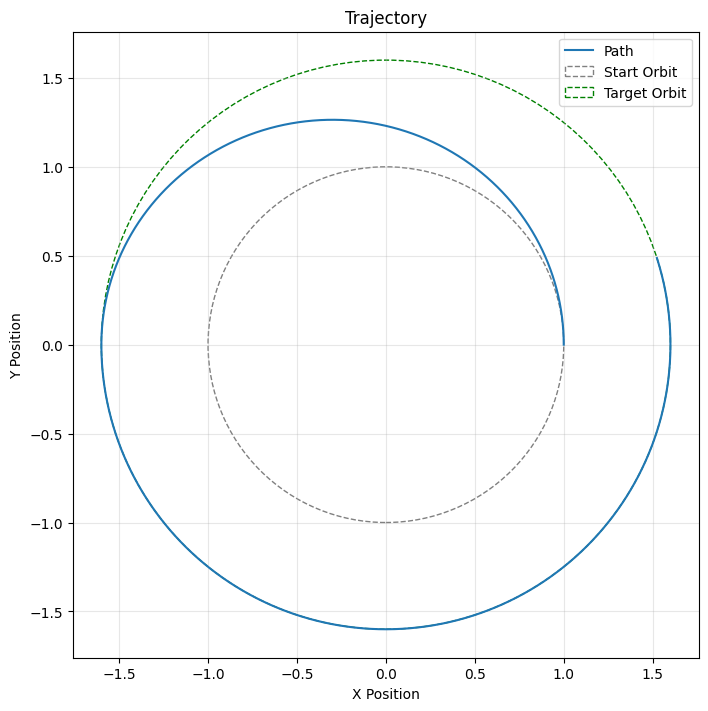

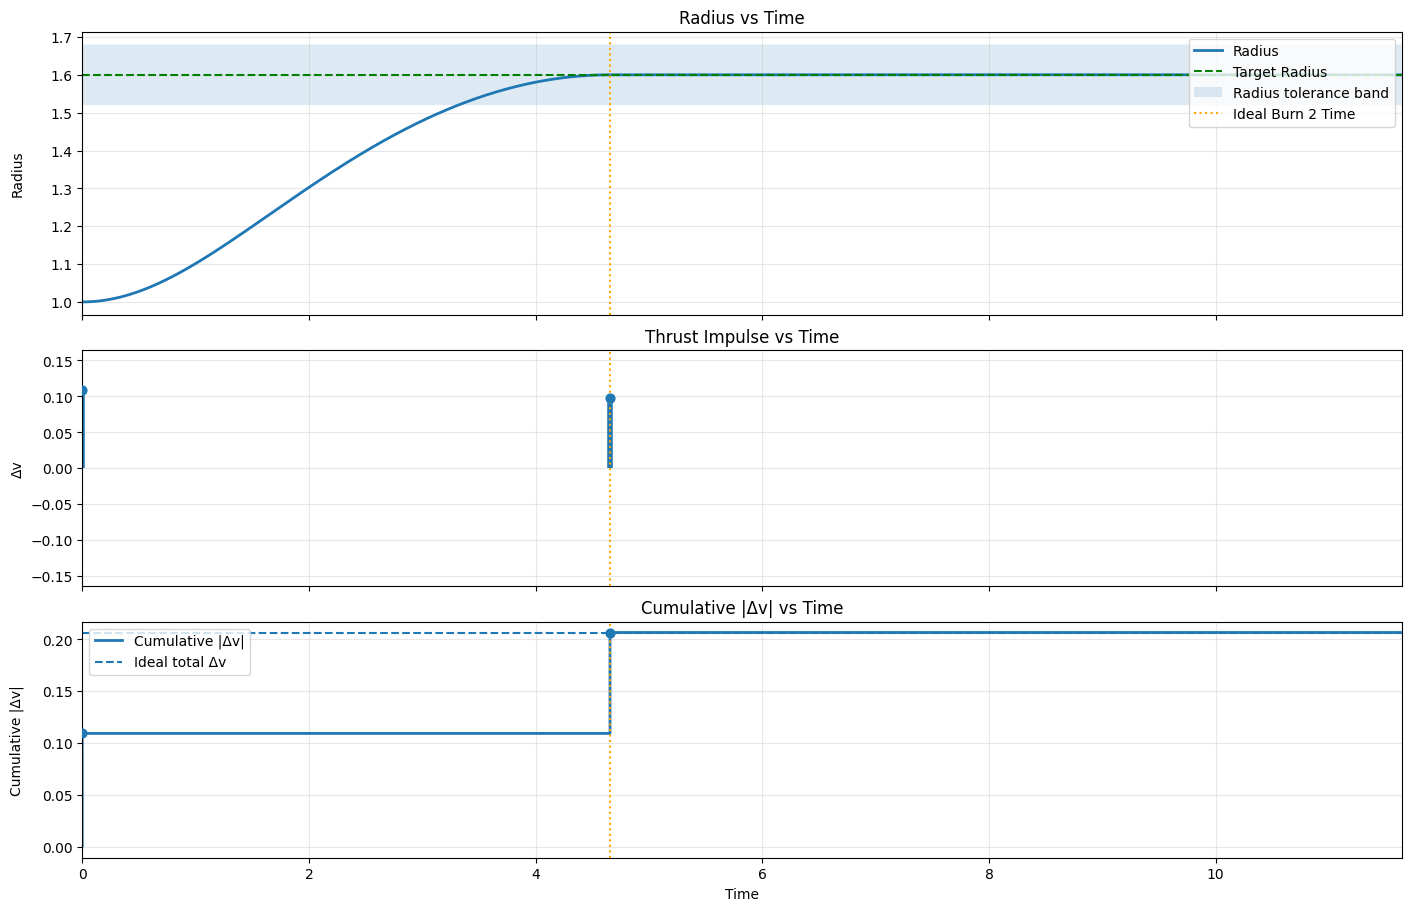

In [6]:
def calculate_hohmann_metrics(r1: float, r2: float, mu: float) -> Tuple[float, float, float, float]:
    # Circular orbit speedsy
    v1_circ = np.sqrt(mu / r1)
    v2_circ = np.sqrt(mu / r2)

    # Transfer orbit semi-major axis
    a_trans = (r1 + r2) / 2.0

    # Transfer orbit speeds at periapsis (r1) and apoapsis (r2)
    v_trans_a = np.sqrt(mu * (2.0 / r1 - 1.0 / a_trans))
    v_trans_b = np.sqrt(mu * (2.0 / r2 - 1.0 / a_trans))

    # Delta-v's
    dv1 = v_trans_a - v1_circ
    dv2 = v2_circ - v_trans_b
    total_dv = abs(dv1) + abs(dv2)

    # Half-period of transfer ellipse
    t_transfer = np.pi * np.sqrt(a_trans**3 / mu)

    return dv1, dv2, t_transfer, total_dv


IDEAL_DV1, IDEAL_DV2, IDEAL_T_TRANS, IDEAL_TOTAL_DV = calculate_hohmann_metrics(
    RADIUS_START, RADIUS_TARGET, GRAVITATIONAL_PARAM_MU
)

print(f"--- THEORETICAL TARGETS ---")
print(f"Radius 1: {RADIUS_START} | Radius 2: {RADIUS_TARGET}")
print(f"Burn 1 (Injection):  {IDEAL_DV1:.4f} m/s")
print(f"Coast Time:          {IDEAL_T_TRANS:.4f} s")
print(f"Burn 2 (Insertion):  {IDEAL_DV2:.4f} m/s")
print(f"---------------------------")
print(f"TOTAL IDEAL DELTA-V: {IDEAL_TOTAL_DV:.4f} m/s")
print(f"---------------------------")

# -----------------------------------------------------------------------------
# Analytic-only sampling control (does NOT affect RL env dt)
# -----------------------------------------------------------------------------
ANALYTIC_OVERSAMPLE = 100            # 10x finer sampling than DT_SECONDS
ANALYTIC_DT_SECONDS = DT_SECONDS / ANALYTIC_OVERSAMPLE


def simulate_analytic_hohmann(
    dt_analytic: float = ANALYTIC_DT_SECONDS,
    t_end_mult: float = 2.5,
    burn2_timing: str = "nearest",  # "nearest" | "ceil" | "ge"
) -> pd.DataFrame:
    """
    Executes the analytic Hohmann transfer as impulsive burns + coasting,
    using the same TwoBodyPhysics integrator as the RL environments,
    but optionally with a *finer dt* for smoother "ideal curve" plotting.

    Args:
        dt_analytic: timestep used ONLY for analytic simulation/plotting.
        t_end_mult: how long to simulate (multiple of IDEAL_T_TRANS).
        burn2_timing:
            - "nearest": burn at the timestep closest to IDEAL_T_TRANS
            - "ceil":    burn at the first timestep strictly after IDEAL_T_TRANS
            - "ge":      burn when (t >= IDEAL_T_TRANS) inside the loop (original behavior)

    Notes:
        Using a smaller dt reduces discretization artifacts in the plotted curve
        and makes burn timing closer to the continuous-time analytic ideal.
    """
    dt = float(dt_analytic)
    if dt <= 0:
        raise ValueError("dt_analytic must be positive")

    phys = TwoBodyPhysics(mu=GRAVITATIONAL_PARAM_MU, dt=dt)

    # Start at r1 on +X axis
    x = np.array([RADIUS_START, 0.0], dtype=np.float64)

    # Circular velocity at r1 along +Y
    v_circ_start = np.sqrt(GRAVITATIONAL_PARAM_MU / RADIUS_START)
    v = np.array([0.0, v_circ_start], dtype=np.float64)

    total_time = IDEAL_T_TRANS * float(t_end_mult)
    steps = int(np.ceil(total_time / dt))

    # Decide exactly which discrete step to apply burn #2
    if burn2_timing == "nearest":
        burn2_step = int(np.round(IDEAL_T_TRANS / dt))
    elif burn2_timing == "ceil":
        burn2_step = int(np.ceil(IDEAL_T_TRANS / dt))
    elif burn2_timing == "ge":
        burn2_step = None  # handled in-loop via (t >= IDEAL_T_TRANS)
    else:
        raise ValueError("burn2_timing must be one of: 'nearest', 'ceil', 'ge'")

    print(f"Simulating Analytic Solution ({steps} steps) with dt={dt:.5f}...")

    data = []
    burn2_done = False

    for step in range(steps):
        t = step * dt

        # Burn 1 at t=0 (instantaneous)
        if step == 0:
            v[1] += IDEAL_DV1
            dv_log = IDEAL_DV1

        # Burn 2 near t = IDEAL_T_TRANS (instantaneous)
        elif not burn2_done:
            if burn2_timing == "ge":
                do_burn2 = (t >= IDEAL_T_TRANS)
            else:
                do_burn2 = (step == burn2_step)

            if do_burn2:
                # Apply Δv2 along current velocity direction (tangential at apoapsis ideally)
                v_norm = v / (np.linalg.norm(v) + EPSILON)
                v += v_norm * IDEAL_DV2
                dv_log = IDEAL_DV2
                burn2_done = True
            else:
                dv_log = 0.0
        else:
            dv_log = 0.0

        r = float(np.linalg.norm(x))
        data.append({"t": t, "x": x[0], "y": x[1], "r": r, "dv": dv_log})

        x, v = phys.step(x, v)

    return pd.DataFrame(data)


df_analytic = simulate_analytic_hohmann()

# --- VERIFICATION REPORT ---
sim_final_r = df_analytic["r"].iloc[-1]
sim_total_dv = df_analytic["dv"].sum()
error_r = abs(sim_final_r - RADIUS_TARGET)

print("\n" + "=" * 40)
print("      PHYSICS ENGINE VERIFICATION      ")
print("=" * 40)
print(f"{'PARAMETER':<20} | {'THEORY':<10} | {'SIMULATION':<10}")
print("-" * 46)
print(f"{'Final Radius':<20} | {RADIUS_TARGET:<10.4f} | {sim_final_r:<10.4f}")
print(f"{'Total Delta-V':<20} | {IDEAL_TOTAL_DV:<10.4f} | {sim_total_dv:<10.4f}")
print("-" * 46)
if error_r < 0.01:
    print(">> SUCCESS: Simulation matches Theory.")
else:
    print(f">> WARNING: Discrepancy detected (Error: {error_r:.4f})")
print("=" * 40 + "\n")


# # --- PLOTTING (ANALYTIC) ---
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# # Trajectory
# ax1.plot(df_analytic["x"], df_analytic["y"], label="Analytic Path", color="purple")
# ax1.add_patch(Circle((0, 0), RADIUS_START, fill=False, linestyle="--", color="gray", label="Start"))
# ax1.add_patch(Circle((0, 0), RADIUS_TARGET, fill=False, linestyle="--", color="green", label="Target"))
# ax1.set_aspect("equal")
# ax1.set_title("Analytic Hohmann Transfer (Trajectory)")
# ax1.legend()
# ax1.grid(True, alpha=0.3)

# # Radius vs Time
# ax2.plot(df_analytic["t"], df_analytic["r"], color="purple", linewidth=2)
# ax2.axhline(RADIUS_TARGET, color="green", linestyle="--", label="Target Radius")
# ax2.axvline(IDEAL_T_TRANS, color="orange", linestyle=":", label="Ideal Burn 2 Time")
# ax2.set_title("Radius vs Time (The 'Step' Profile)")
# ax2.set_xlabel("Time (arb. units)")
# ax2.set_ylabel("Radius")
# ax2.legend()
# ax2.grid(True, alpha=0.3)

# plt.show()

# Analytic
plot_results(df_analytic, dv_max=max(abs(IDEAL_DV1), abs(IDEAL_DV2)))


## Unified Gymnasium Environment (Discrete or Continuous)

### Turning physics into an RL environment

Gym environments define:

- **Observation** (what the agent sees)
- **Action** (what the agent can do)
- **Reward** (what the agent is trying to maximize)
- **Termination conditions** (success, crash, timeout)

Key design choices here:

#### Observation (6 numbers)
We do *not* give the agent the orbital angle.
Instead, we give it orbit-relevant quantities:
- normalized radius r
- radial velocity vr
- tangential velocity vt
- angular momentum error (via L)
- energy error (via E)
- the previous action (helps prevent jitter)

This makes the policy naturally rotationally symmetric (same behavior at any angle).

#### Action: discrete vs continuous
- Discrete (“bang-bang”): coast / full prograde / full retrograde
- Continuous: throttle in [-1, +1] → smooth prograde/retrograde Δv each step

#### Reward shaping (important!)
Our reward is **potential-based shaping** using errors in energy and angular momentum.
This gives dense learning signals instead of “0 reward until success”.

But shaping can also create failure modes:
- the agent learns to “hover-thrust” to keep errors low
- fuel/ignition penalties must be tuned to encourage efficient solutions

#### Success criteria (TODO: consolidate one of target and 2)
We don’t require perfect r2; we accept a tolerance on:
- |r − r2|
- |vr| (near-circular, not spiraling)
- |L − L_target|

That means a policy can look “successful” while still being slightly elliptical.


In [7]:
class HohmannEnv(gym.Env):
    """
    Single environment that can reproduce BOTH notebooks, controlled by ModeConfig.

    - DISCRETE: action space Discrete(3)
        0 = coast
        1 = prograde impulse (+dv_mag)
        2 = retrograde impulse (-dv_mag)

    - CONTINUOUS: action space Box([-1, +1], shape=(1,))
        throttle in [-1, +1]
        dv_val = throttle * dv_mag
    """
    metadata = {"render_modes": []}

    def __init__(
        self,
        mode_cfg: ModeConfig,
        r1: float = RADIUS_START,
        r2: float = RADIUS_TARGET,
        mu: float = GRAVITATIONAL_PARAM_MU,
        dt: float = DT_SECONDS,
        terminate_on_success: bool = False,
        seed: Optional[int] = None,
    ) -> None:
        super().__init__()

        if mode_cfg.control_mode not in ("discrete", "continuous"):
            raise ValueError(f"Unknown control_mode: {mode_cfg.control_mode}")

        self.cfg = mode_cfg
        self.r1 = float(r1)
        self.r2 = float(r2)
        self.mu = float(mu)
        self.dt = float(dt)
        self.terminate_on_success = terminate_on_success

        self.phys = TwoBodyPhysics(mu=self.mu, dt=self.dt)

        # Target circular orbit invariants at r2
        self._L_target = np.sqrt(self.mu * self.r2)
        self._E_target = -self.mu / (2.0 * self.r2)
        self._v_circ_r2 = np.sqrt(self.mu / self.r2)

        # --- Success tolerances (absolute) computed once ---
        self._r_tol = SUCCESS_R_TOL_FRAC * self.r2
        self._vr_tol = SUCCESS_VR_TOL_FRAC * self._v_circ_r2
        self._L_tol = SUCCESS_L_TOL_FRAC * self._L_target

        # Episode length (same formula in both notebooks)
        T_half_period = np.pi * np.sqrt(((self.r1 + self.r2) / 2.0) ** 3 / self.mu)
        self.max_steps = int(np.ceil(self.cfg.max_orbits_limit * 2.0 * T_half_period / self.dt))

        # Observation: [norm_r, norm_vr, norm_vt, norm_L, norm_E, last_action]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)

        # Action space depends on mode
        if self.cfg.control_mode == "discrete":
            self.action_space = spaces.Discrete(3)
        else:
            self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        self._rng = None
        self.seed(seed)

    def seed(self, seed: Optional[int] = None):
        self._rng, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)

        # Start on r1 at a random angle
        theta = self._rng.uniform(0, 2 * np.pi)
        self.x = np.array([self.r1 * np.cos(theta), self.r1 * np.sin(theta)])

        # Circular velocity at r1
        v_mag = np.sqrt(self.mu / self.r1)
        self.v = v_mag * np.array([-np.sin(theta), np.cos(theta)])

        self._step_count = 0
        self._cum_dv = 0.0
        self._bonus_given = False

        # prev_action storage differs by mode (exactly matches each notebook)
        if self.cfg.control_mode == "discrete":
            self._prev_action = 0      # int
            last_act_for_obs = 0
        else:
            self._prev_action = 0.0    # float
            last_act_for_obs = 0.0

        r, vr, vt, _, _, L = polar_components(self.x, self.v)
        E = energy(self.x, self.v, self.mu)
        self._prev_error = self._get_error(E, L)

        return self._make_obs(r, vr, vt, L, E, last_act_for_obs), {}

    def step(self, action):
        # ------------------------------------------------------------
        # 1) Interpret action -> (dv_val, action_feature_for_obs)
        # ------------------------------------------------------------
        if self.cfg.control_mode == "discrete":
            act = int(action)
            dv_val = 0.0
            if act == 1:
                dv_val = self.cfg.dv_mag
            elif act == 2:
                dv_val = -self.cfg.dv_mag

            action_feature_for_obs = act

        else:
            # action arrives as np.ndarray like [0.75]
            throttle = float(np.clip(action[0], -1.0, 1.0))
            dv_val = throttle * self.cfg.dv_mag
            action_feature_for_obs = throttle

        # ------------------------------------------------------------
        # 2) Apply impulse in tangential direction (same in both)
        # ------------------------------------------------------------
        _, _, _, _, et, _ = polar_components(self.x, self.v)
        self.v = self.v + dv_val * et
        self._cum_dv += abs(dv_val)

        # ------------------------------------------------------------
        # 3) Physics step
        # ------------------------------------------------------------
        self.x, self.v = self.phys.step(self.x, self.v)
        self._step_count += 1

        # ------------------------------------------------------------
        # 4) Compute state metrics
        # ------------------------------------------------------------
        r, vr, vt, _, _, L = polar_components(self.x, self.v)
        E = energy(self.x, self.v, self.mu)

        # ------------------------------------------------------------
        # 5) Reward (potential-based shaping + costs)
        # ------------------------------------------------------------
        current_error = self._get_error(E, L)
        shaping_reward = (self._prev_error - self.cfg.discount_gamma * current_error) * self.cfg.reward_shaping_scale
#         shaping_reward = (self._prev_error - current_error) * self.cfg.reward_shaping_scale

        self._prev_error = current_error

        if self.cfg.control_mode == "discrete":
            burn_cost = 0.0
            ignition_penalty = 0.0
            act = int(action_feature_for_obs)

            if act != 0:
                burn_cost = self.cfg.fuel_cost_penalty
                # EXACT discrete logic: penalty if toggling on OR switching direction
                if (self._prev_action == 0) or (self._prev_action != act):
                    ignition_penalty = self.cfg.ignition_penalty

            self._prev_action = act

        else:
            throttle = float(action_feature_for_obs)

            # EXACT continuous logic: cost proportional to |throttle|
            burn_cost = abs(throttle) * self.cfg.fuel_cost_penalty

            # EXACT continuous logic: penalize throttle changes with * (IGNITION_PENALTY * 0.1)
            throttle_delta = abs(throttle - self._prev_action)
            ignition_penalty = throttle_delta * (self.cfg.ignition_penalty * self.cfg.continuous_ignition_delta_scale)

            self._prev_action = throttle

        reward = shaping_reward - burn_cost - ignition_penalty

        # ------------------------------------------------------------
        # 6) Termination checks (same in both notebooks)
        # ------------------------------------------------------------
        terminated = False
        truncated = (self._step_count >= self.max_steps)
        done_reason = ""

        r_ok = abs(r - self.r2) < self._r_tol
        v_ok = abs(vr) < self._vr_tol
        L_ok = abs(L - self._L_target) < self._L_tol

        is_success = r_ok and v_ok and L_ok

        is_crash = (r < RADIUS_MIN_LIMIT) or (r > RADIUS_MAX_LIMIT)

        if is_success:
            r_err_norm = abs(r - self.r2) / (self._r_tol + EPSILON)
            precision_factor = max(0.0, 1.0 - r_err_norm)

            reward += self.cfg.holding_reward * (0.5 + 0.5 * precision_factor)

            if not self._bonus_given:
                reward += self.cfg.success_bonus
                self._bonus_given = True

            if self.terminate_on_success:
                terminated = True
                done_reason = "success"
            else:
                done_reason = "holding"

        elif is_crash:
            terminated = True
            done_reason = "crash"
            reward -= self.cfg.success_bonus

        elif truncated:
            done_reason = "timeout"

        info = {
            "r": r,
            "vr": vr,
            "dv": dv_val,
            "cum_dv": self._cum_dv,
            "done_reason": done_reason,
            "is_success": is_success,
            "x": self.x[0],
            "y": self.x[1],
            "E_err": abs(E - self._E_target),
            "L_err": abs(L - self._L_target),
            "r_tol": self._r_tol,
            "vr_tol": self._vr_tol,
            "L_tol": self._L_tol,
        }

        obs = self._make_obs(r, vr, vt, L, E, action_feature_for_obs)
        return obs, float(reward), terminated, truncated, info

    def _get_error(self, E: float, L: float) -> float:
        """Combined normalized error of Energy and Angular Momentum (same in both notebooks)."""
        E_err = abs(E - self._E_target) / abs(self._E_target)
        L_err = abs(L - self._L_target) / abs(self._L_target)
        return E_err + L_err

    def _make_obs(self, r: float, vr: float, vt: float, L: float, E: float, last_act) -> np.ndarray:
        """
        Normalize observations for neural network stability.
        The final component matches each notebook exactly:
          - discrete: last_act / 2.0
          - continuous: last_act (already in [-1, +1])
        """
        norm_r = (r - self.r1) / (self.r2 - self.r1)
        norm_vr = vr / self._v_circ_r2 # What is normalization v_circ_r2? Put units for normalization.
        norm_vt = (vt - self._v_circ_r2) / self._v_circ_r2
        norm_L = (L - self._L_target) / self._L_target
        norm_E = (E - self._E_target) / abs(self._E_target)

        if self.cfg.control_mode == "discrete":
            norm_act = float(last_act) / 2.0
        else:
            norm_act = float(last_act)

        return np.array([norm_r, norm_vr, norm_vt, norm_L, norm_E, norm_act], dtype=np.float32)


## Shared Training / Visualization / Plotting Utilities

### Training and evaluation pipeline (shared across experiments)

This section contains the RL “plumbing”:

- `DummyVecEnv`: wraps a single environment in a vectorized interface.
- `VecNormalize`: normalizes observations/rewards (critical for PPO stability).
- PPO training: learns a policy network that maps observations → actions.

Two important distinctions:

#### Training vs Evaluation
- During training, VecNormalize updates running statistics.
- During evaluation, we freeze those statistics and **sync** them from the training env.

#### Why we stop on done (Fix #2)
If we keep stepping after an episode ends, the environment resets automatically and we’d silently log multiple episodes.
That makes “final radius” and plots confusing.

#### Why we print closest-to-target (Fix #1)
For an elliptical orbit, the radius changes around the orbit.
A single “final radius” number can be misleading.
So we print:
- closest approach to r2
- min/max/mean/std radius (and last-N stats)


In [8]:
def make_env_factory(
    mode_cfg: ModeConfig,
    terminate_on_success: bool = False,
    seed: Optional[int] = None,
) -> Callable[[], gym.Env]:
    def _factory():
        return HohmannEnv(
            mode_cfg=mode_cfg,
            r1=RADIUS_START,
            r2=RADIUS_TARGET,
            mu=GRAVITATIONAL_PARAM_MU,
            dt=DT_SECONDS,
            terminate_on_success=terminate_on_success,
            seed=seed,
        )
    return _factory

def train_ppo_agent(
    mode_cfg: ModeConfig,
    env_factory: Callable[[], gym.Env],
    eval_env_factory: Optional[Callable[[], gym.Env]] = None,
    eval_freq: int = 10_000,
    n_eval_episodes: int = 10,
) -> Tuple[PPO, PPO, VecNormalize]:
    """
    Trains PPO, saves the best model (by eval mean reward), loads it,
    and returns (best_model, final_model, train_env).

    Notes:
    - Best is defined by EvalCallback's mean episodic reward.
    - We keep train_env in-memory for VecNormalize stats (needed for proper inference).
    """
    if eval_env_factory is None:
        eval_env_factory = env_factory

    # --- 1) Training env (updates normalization stats) ---
    train_env = DummyVecEnv([env_factory])
    train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

    # --- 2) Eval env (frozen stats, no reward normalization) ---
    eval_env = DummyVecEnv([eval_env_factory])
    eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.0, training=False)

    # Safe + explicit: keep eval env using the same obs normalization as training.
    # (Even if EvalCallback already does this internally, this is harmless and clarifies intent.)
    sync_envs_normalization(train_env, eval_env)

    # --- 3) Callback setup ---
    log_dir = tempfile.mkdtemp(prefix="tmp_best_model_")
    best_model_file = os.path.join(log_dir, "best_model.zip")

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=log_dir,   # saves best_model.zip into this directory
        log_path=log_dir,
        eval_freq=eval_freq,
        n_eval_episodes=n_eval_episodes,
        deterministic=True,
        render=False,
    )

    # --- 4) Train final model ---
    print(f"Initializing PPO Agent for: {mode_cfg.name}")
    final_model = PPO(
        "MlpPolicy",
        train_env,
        verbose=1,
        learning_rate=mode_cfg.learning_rate,
        ent_coef=mode_cfg.ent_coef,
        gamma=mode_cfg.discount_gamma,   # keep PPO gamma aligned with your config
    )

    print(f"Starting training for {mode_cfg.training_timesteps} timesteps...")
    final_model.learn(
        total_timesteps=mode_cfg.training_timesteps,
        callback=eval_callback,
        progress_bar=True,
    )
    print("Training Complete.\n")

    # --- 5) Load best model (fallback to final if missing) ---
    if os.path.exists(best_model_file):
        best_model = PPO.load(best_model_file)
        print("Loaded best model from disk (highest eval mean reward checkpoint).")
    else:
        best_model = final_model
        print("WARNING: No best_model.zip found (eval may not have run). Using final model instead.")

    # Optional: attach env so best_model can be further trained if needed.
    # (Not required for .predict(), but helpful if you later call .learn() on best_model.)
    try:
        best_model.set_env(train_env)
    except Exception:
        pass

    # Cleanup: if you want to keep eval logs/curves, comment this out.
    shutil.rmtree(log_dir, ignore_errors=True)

    return best_model, final_model, train_env


def visualize_agent(
    model: PPO,
    train_env: VecNormalize,
    env_factory: Callable[[], gym.Env],
    steps: int = 800,
) -> pd.DataFrame:
    """
    Runs the trained agent (deterministic policy) and collects telemetry.

    Fix #2:
      - Stop on ANY episode termination (done), not just crash.
        (Otherwise VecEnv will auto-reset and your trace may silently include multiple episodes.)
    """
    viz_env = DummyVecEnv([env_factory])
    viz_env = VecNormalize(viz_env, norm_obs=True, norm_reward=False, clip_obs=10.0, training=False)

    # copy normalization stats
    sync_envs_normalization(train_env, viz_env)

    obs = viz_env.reset()
    data = []

    print(f"Simulating Agent ({steps} steps)...")
    for i in range(steps):
        action, _ = model.predict(obs, deterministic=True)
        obs_new, rewards, dones, infos = viz_env.step(action)

        info = infos[0]
        data.append(
            {
                "t": i * DT_SECONDS,
                "x": info["x"],
                "y": info["y"],
                "r": info["r"],
                "vr": info["vr"],
                "dv": info["dv"],
                "E_err": info["E_err"],
                "L_err": info["L_err"],
                "done_reason": info["done_reason"],
            }
        )

        # Fix #2: stop if the episode ended for any reason
        if bool(dones[0]):
            print(f"Episode ended: {info['done_reason']} at t={i * DT_SECONDS:.2f}s")
            break

        obs = obs_new

    return pd.DataFrame(data)

def print_mission_report(df: pd.DataFrame, mode_cfg: ModeConfig):
    """
    Prints the same report structure as the original notebooks,
    including the discrete/continuous-specific "Burn Count" vs "Active Steps".
    """
    total_dv = df["dv"].abs().sum()
    final_r = df["r"].iloc[-1] if len(df) > 0 else float("nan")

    print("\n" + "=" * 40)
    print(f"   MISSION REPORT: {mode_cfg.name} vs IDEAL   ")
    print("=" * 40)
    print(f"{'PARAMETER':<20} | {'IDEAL':<10} | {'AGENT':<10}")
    print("-" * 46)
    print(f"{'Final Radius':<20} | {RADIUS_TARGET:<10.4f} | {final_r:<10.4f}")
    print(f"{'Total Delta-V':<20} | {IDEAL_TOTAL_DV:<10.4f} | {total_dv:<10.4f}")

    if mode_cfg.control_mode == "discrete":
        burn_count = int((df["dv"] != 0).sum())
        print(f"{'Burn Count':<20} | {'2':<10} | {burn_count:<10}")
    else:
        active_steps = int((df["dv"].abs() > (mode_cfg.dv_mag * 0.01)).sum())
        print(f"{'Active Steps':<20} | {'2':<10} | {active_steps:<10}")

    print("-" * 46)
    efficiency = ((total_dv + 1e-6) / IDEAL_TOTAL_DV)
    print(f"Efficiency (Agent/Ideal): {efficiency:2.2f}")
    print("=" * 40 + "\n")

### RL Experiments

## Experiment structure

For each experiment we will:
1. **Train** a policy from scratch using PPO.
2. **Evaluate** it with deterministic actions.
3. Inspect:
   - trajectory plot
   - radius-vs-time plot
   - thrust profile
   - mission report (Δv usage, number of burns/active steps)
   - closest-to-target diagnostics

Then we’ll use failures as evidence for the next experiment.

A note about RL randomness:
Training is stochastic (random initialization + exploration + randomized starting angle),
so results can vary across runs. That’s normal in RL.


## Experiment 1: Discrete control (“bang-bang”)

In this baseline, the agent’s thruster is like a simple digital engine:
- OFF
- FULL PROGRADE
- FULL RETROGRADE

Expected behavior:
- It can learn to reach the target region,
- but it often uses many small burns (“chattering”) and wastes Δv.

What to look for:
- Thrust plot: lots of green/red bars (many burns).
- Mission report: Δv much larger than ideal.
- Radius plot: may overshoot and correct repeatedly.

Why this is useful:
It establishes a working RL baseline and highlights the cost of coarse actions.
This motivates the next step: **continuous throttle**.


In [9]:
# =============================================================================
# DISCRETE (BANG-BANG) RL
# =============================================================================

mode_cfg_discrete = DISCRETE_CFG
train_factory_discrete = make_env_factory(mode_cfg_discrete, terminate_on_success=False)
best_model_discrete, final_model_discrete, train_env_discrete = train_ppo_agent(mode_cfg_discrete, train_factory_discrete)

Initializing PPO Agent for: Discrete (Bang-Bang)
Using cpu device


Output()

Starting training for 300000 timesteps...
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    fps             | 1902     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    success_rate         | 0          |
| time/                   |            |
|    fps                  | 1493       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01505006 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.09      |
|    explained_variance   | -0.207     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.179    

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=10000, episode_reward=30.10 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 0.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 30.1        |
|    success_rate         | 0           |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.011656317 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.753       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0503     |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 0.00772     |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    fps             | 837      |
|    iterations      | 5        |
|    time_elapsed    | 12       |
|    total_timesteps | 10240    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0           |
| time/                   |             |
|    fps                  | 887         |
|    iterations           | 6           |
|    time_elapsed         | 13          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.006331276 |
|    clip_fraction        | 0.023       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.211       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0834      |
|    n_updates        

Eval num_timesteps=20000, episode_reward=30.10 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 0.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 30.1        |
|    success_rate         | 0           |
| time/                   |             |
|    total_timesteps      | 20000       |
| train/                  |             |
|    approx_kl            | 0.011737237 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.978      |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00591    |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0145     |
|    value_loss           | 0.0157      |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    fps             | 822      |
|    iterations      | 10       

Eval num_timesteps=30000, episode_reward=1625.50 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.63e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 30000        |
| train/                  |              |
|    approx_kl            | 0.0074970117 |
|    clip_fraction        | 0.0787       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.972       |
|    explained_variance   | 0.808        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00348     |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00707     |
|    value_loss           | 0.0498       |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.154    |
| time/              |          |
|    fps             | 816      |
|    iterations      | 15       |
|    time_elapsed    | 37       |
|    total_timesteps | 30720    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.148       |
| time/                   |             |
|    fps                  | 834         |
|    iterations           | 16          |
|    time_elapsed         | 39          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.011082146 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.988      |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0351     |
|    n_updates        

Eval num_timesteps=40000, episode_reward=2009.23 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.49e+03   |
|    mean_reward          | 2.01e+03   |
|    success_rate         | 1          |
| time/                   |            |
|    total_timesteps      | 40000      |
| train/                  |            |
|    approx_kl            | 0.00944887 |
|    clip_fraction        | 0.0615     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.951     |
|    explained_variance   | 0.967      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0132    |
|    n_updates            | 190        |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 0.00539    |
----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.303    |
| time/              |          |
|    fps             | 811      |
|    iterations      | 20       |
|    time_elapsed    | 50       |
|    total_timesteps | 40960    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.324       |
| time/                   |             |
|    fps                  | 825         |
|    iterations           | 21          |
|    time_elapsed         | 52          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.009765905 |
|    clip_fraction        | 0.0935      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.942      |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0188     |
|    n_updates        

Eval num_timesteps=50000, episode_reward=30.10 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 0.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 30.1         |
|    success_rate         | 0            |
| time/                   |              |
|    total_timesteps      | 50000        |
| train/                  |              |
|    approx_kl            | 0.0106882695 |
|    clip_fraction        | 0.171        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.9         |
|    explained_variance   | 0.986        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0201      |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00886     |
|    value_loss           | 0.0012       |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.41     |
| time/              |          |
|    fps             | 808      |
|    iteratio

Eval num_timesteps=60000, episode_reward=30.10 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 0.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 30.1        |
|    success_rate         | 0           |
| time/                   |             |
|    total_timesteps      | 60000       |
| train/                  |             |
|    approx_kl            | 0.007529254 |
|    clip_fraction        | 0.0548      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.785      |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00974     |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00368    |
|    value_loss           | 0.00149     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.5      |
| time/              |          |
|    fps             | 807      |
|    iterations      | 30       

Eval num_timesteps=70000, episode_reward=1934.07 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.93e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 70000       |
| train/                  |             |
|    approx_kl            | 0.005839379 |
|    clip_fraction        | 0.0667      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.712      |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0206     |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0045     |
|    value_loss           | 0.0013      |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.566    |
| time/              |          |
|    fps             | 808      |
|    iterations      | 35       

Eval num_timesteps=80000, episode_reward=2594.51 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.59e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 80000        |
| train/                  |              |
|    approx_kl            | 0.0052620675 |
|    clip_fraction        | 0.0451       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.618       |
|    explained_variance   | 0.982        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00537      |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.00249     |
|    value_loss           | 0.00115      |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.617    |
| time/              |          |
|    fps             | 807      |
|    iterations      | 40       |
|    time_elapsed    | 101      |
|    total_timesteps | 81920    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    success_rate         | 0.623        |
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 41           |
|    time_elapsed         | 103          |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0071225693 |
|    clip_fraction        | 0.0868       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.53        |
|    explained_variance   | 0.983        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0519      |
|    n

Eval num_timesteps=90000, episode_reward=2568.31 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.57e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 90000        |
| train/                  |              |
|    approx_kl            | 0.0048484635 |
|    clip_fraction        | 0.0395       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.452       |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00948     |
|    n_updates            | 430          |
|    policy_gradient_loss | -0.00324     |
|    value_loss           | 0.000563     |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.646    |
| time/              |          |
|    fps             | 800      |
|    iteratio

Eval num_timesteps=100000, episode_reward=2628.42 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.63e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 100000       |
| train/                  |              |
|    approx_kl            | 0.0048851194 |
|    clip_fraction        | 0.0636       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.42        |
|    explained_variance   | 0.983        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00829      |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.00284     |
|    value_loss           | 0.000559     |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.681    |
| time/              |          |
|    fps             | 801      |
|    iterations      | 49       |
|    time_elapsed    | 125      |
|    total_timesteps | 100352   |
---------------------------------
----------------------------------------
| rollout/                |            |
|    success_rate         | 0.689      |
| time/                   |            |
|    fps                  | 807        |
|    iterations           | 50         |
|    time_elapsed         | 126        |
|    total_timesteps      | 102400     |
| train/                  |            |
|    approx_kl            | 0.00350977 |
|    clip_fraction        | 0.0353     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.407     |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0146    |
|    n_updates            | 490       

Eval num_timesteps=110000, episode_reward=2604.36 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.6e+03      |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 110000       |
| train/                  |              |
|    approx_kl            | 0.0056514386 |
|    clip_fraction        | 0.0644       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.408       |
|    explained_variance   | 0.983        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0173      |
|    n_updates            | 530          |
|    policy_gradient_loss | -0.00692     |
|    value_loss           | 0.00112      |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.709    |
| time/              |          |
|    fps             | 802      |
|    iteratio

Eval num_timesteps=120000, episode_reward=2650.61 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 2.65e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 120000      |
| train/                  |             |
|    approx_kl            | 0.005356471 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.443      |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.012      |
|    n_updates            | 580         |
|    policy_gradient_loss | -0.00288    |
|    value_loss           | 0.000883    |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.733    |
| time/              |          |
|    fps             | 803      |
|    iterations      | 59       |
|    time_elapsed    | 150      |
|    total_timesteps | 120832   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    success_rate         | 0.736        |
| time/                   |              |
|    fps                  | 808          |
|    iterations           | 60           |
|    time_elapsed         | 152          |
|    total_timesteps      | 122880       |
| train/                  |              |
|    approx_kl            | 0.0025182923 |
|    clip_fraction        | 0.0373       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.404       |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.005        |
|    n

Eval num_timesteps=130000, episode_reward=2681.03 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.68e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 130000       |
| train/                  |              |
|    approx_kl            | 0.0030391403 |
|    clip_fraction        | 0.0369       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.356       |
|    explained_variance   | 0.99         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.029        |
|    n_updates            | 630          |
|    policy_gradient_loss | -0.00463     |
|    value_loss           | 0.000784     |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.753    |
| time/              |          |
|    fps             | 803      |
|    iterations      | 64       |
|    time_elapsed    | 163      |
|    total_timesteps | 131072   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.755       |
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 65          |
|    time_elapsed         | 164         |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.004264244 |
|    clip_fraction        | 0.0418      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.375      |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0155     |
|    n_updates        

Eval num_timesteps=140000, episode_reward=2689.81 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 2.69e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 140000      |
| train/                  |             |
|    approx_kl            | 0.004832143 |
|    clip_fraction        | 0.0457      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.354      |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00303    |
|    n_updates            | 680         |
|    policy_gradient_loss | -0.00304    |
|    value_loss           | 0.000509    |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.77     |
| time/              |          |
|    fps             | 803      |
|    iterations      | 69       |
|    time_elapsed    | 175      |
|    total_timesteps | 141312   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    success_rate         | 0.78         |
| time/                   |              |
|    fps                  | 808          |
|    iterations           | 70           |
|    time_elapsed         | 177          |
|    total_timesteps      | 143360       |
| train/                  |              |
|    approx_kl            | 0.0060157953 |
|    clip_fraction        | 0.0693       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.364       |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0243      |
|    n

Eval num_timesteps=150000, episode_reward=2695.68 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.7e+03      |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 150000       |
| train/                  |              |
|    approx_kl            | 0.0035970907 |
|    clip_fraction        | 0.0709       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.336       |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0333      |
|    n_updates            | 730          |
|    policy_gradient_loss | -0.00783     |
|    value_loss           | 0.000447     |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.84     |
| time/              |          |
|    fps             | 804      |
|    iterations      | 74       |
|    time_elapsed    | 188      |
|    total_timesteps | 151552   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.85        |
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 75          |
|    time_elapsed         | 189         |
|    total_timesteps      | 153600      |
| train/                  |             |
|    approx_kl            | 0.005774769 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.35       |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0142     |
|    n_updates        

Eval num_timesteps=160000, episode_reward=2699.88 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.7e+03      |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 160000       |
| train/                  |              |
|    approx_kl            | 0.0032812068 |
|    clip_fraction        | 0.061        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.313       |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00273      |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.00439     |
|    value_loss           | 0.000352     |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.91     |
| time/              |          |
|    fps             | 804      |
|    iterations      | 79       |
|    time_elapsed    | 201      |
|    total_timesteps | 161792   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    success_rate         | 0.92         |
| time/                   |              |
|    fps                  | 808          |
|    iterations           | 80           |
|    time_elapsed         | 202          |
|    total_timesteps      | 163840       |
| train/                  |              |
|    approx_kl            | 0.0018946824 |
|    clip_fraction        | 0.0218       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.291       |
|    explained_variance   | 0.992        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0121      |
|    n

Eval num_timesteps=170000, episode_reward=2710.37 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.71e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 170000       |
| train/                  |              |
|    approx_kl            | 0.0020287454 |
|    clip_fraction        | 0.0229       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.349       |
|    explained_variance   | 0.988        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0103       |
|    n_updates            | 830          |
|    policy_gradient_loss | -0.0025      |
|    value_loss           | 0.000448     |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.97     |
| time/              |          |
|    fps             | 805      |
|    iterations      | 84       |
|    time_elapsed    | 213      |
|    total_timesteps | 172032   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.99        |
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 85          |
|    time_elapsed         | 215         |
|    total_timesteps      | 174080      |
| train/                  |             |
|    approx_kl            | 0.002768007 |
|    clip_fraction        | 0.0475      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.3        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00166     |
|    n_updates        

Eval num_timesteps=180000, episode_reward=2716.29 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.72e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 180000       |
| train/                  |              |
|    approx_kl            | 0.0030444637 |
|    clip_fraction        | 0.0302       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.305       |
|    explained_variance   | 0.986        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0328      |
|    n_updates            | 870          |
|    policy_gradient_loss | -0.00213     |
|    value_loss           | 0.000704     |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.99     |
| time/              |          |
|    fps             | 802      |
|    iterations      | 88       |
|    time_elapsed    | 224      |
|    total_timesteps | 180224   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    success_rate         | 1            |
| time/                   |              |
|    fps                  | 805          |
|    iterations           | 89           |
|    time_elapsed         | 226          |
|    total_timesteps      | 182272       |
| train/                  |              |
|    approx_kl            | 0.0037769452 |
|    clip_fraction        | 0.0456       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.307       |
|    explained_variance   | 0.971        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0119      |
|    n

Eval num_timesteps=190000, episode_reward=2728.47 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.73e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 190000       |
| train/                  |              |
|    approx_kl            | 0.0018974438 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.252       |
|    explained_variance   | 0.982        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00995     |
|    n_updates            | 920          |
|    policy_gradient_loss | -0.00371     |
|    value_loss           | 0.000664     |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 802      |
|    iterations      | 93       |
|    time_elapsed    | 237      |
|    total_timesteps | 190464   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 1           |
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 94          |
|    time_elapsed         | 238         |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.007201058 |
|    clip_fraction        | 0.0485      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.278      |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0147     |
|    n_updates        

Eval num_timesteps=200000, episode_reward=2702.28 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.7e+03      |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 200000       |
| train/                  |              |
|    approx_kl            | 0.0015030741 |
|    clip_fraction        | 0.0199       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.298       |
|    explained_variance   | 0.991        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0183      |
|    n_updates            | 970          |
|    policy_gradient_loss | -0.00318     |
|    value_loss           | 0.000335     |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 802      |
|    iteratio

Eval num_timesteps=210000, episode_reward=2728.45 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.73e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 210000       |
| train/                  |              |
|    approx_kl            | 0.0016551857 |
|    clip_fraction        | 0.0258       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.229       |
|    explained_variance   | 0.986        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00489      |
|    n_updates            | 1020         |
|    policy_gradient_loss | -0.0025      |
|    value_loss           | 0.000414     |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 803      |
|    iteratio

Eval num_timesteps=220000, episode_reward=2767.18 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 2.77e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 220000      |
| train/                  |             |
|    approx_kl            | 0.005964855 |
|    clip_fraction        | 0.0514      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.025      |
|    n_updates            | 1070        |
|    policy_gradient_loss | -0.0051     |
|    value_loss           | 0.000245    |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 803      |
|    iterations      | 108      |
|    time_elapsed    | 275      |
|    total_timesteps | 221184   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    success_rate         | 1            |
| time/                   |              |
|    fps                  | 806          |
|    iterations           | 109          |
|    time_elapsed         | 276          |
|    total_timesteps      | 223232       |
| train/                  |              |
|    approx_kl            | 0.0032224508 |
|    clip_fraction        | 0.0452       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.206       |
|    explained_variance   | 0.992        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0129      |
|    n

Eval num_timesteps=230000, episode_reward=2778.44 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.78e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 230000       |
| train/                  |              |
|    approx_kl            | 0.0036728568 |
|    clip_fraction        | 0.0384       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.215       |
|    explained_variance   | 0.981        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000756    |
|    n_updates            | 1120         |
|    policy_gradient_loss | -0.00376     |
|    value_loss           | 0.00107      |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 803      |
|    iterations      | 113      |
|    time_elapsed    | 287      |
|    total_timesteps | 231424   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 1           |
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 114         |
|    time_elapsed         | 289         |
|    total_timesteps      | 233472      |
| train/                  |             |
|    approx_kl            | 0.005594303 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.022      |
|    n_updates        

Eval num_timesteps=240000, episode_reward=2746.90 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.75e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 240000       |
| train/                  |              |
|    approx_kl            | 0.0060036844 |
|    clip_fraction        | 0.0226       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.144       |
|    explained_variance   | 0.924        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00381     |
|    n_updates            | 1170         |
|    policy_gradient_loss | 0.002        |
|    value_loss           | 0.000879     |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 804      |
|    iteratio

Eval num_timesteps=250000, episode_reward=2759.31 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 2.76e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 250000      |
| train/                  |             |
|    approx_kl            | 0.010838088 |
|    clip_fraction        | 0.063       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.281      |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00536    |
|    n_updates            | 1220        |
|    policy_gradient_loss | -0.00529    |
|    value_loss           | 0.000553    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 804      |
|    iterations      | 123      

Eval num_timesteps=260000, episode_reward=2760.55 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.76e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 260000       |
| train/                  |              |
|    approx_kl            | 0.0024378311 |
|    clip_fraction        | 0.0306       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.142       |
|    explained_variance   | 0.961        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00837     |
|    n_updates            | 1260         |
|    policy_gradient_loss | -0.00868     |
|    value_loss           | 0.000326     |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 802      |
|    iteratio

Eval num_timesteps=270000, episode_reward=2766.44 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.77e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 270000       |
| train/                  |              |
|    approx_kl            | 0.0010172967 |
|    clip_fraction        | 0.0152       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.104       |
|    explained_variance   | 0.997        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0206      |
|    n_updates            | 1310         |
|    policy_gradient_loss | -0.000648    |
|    value_loss           | 0.000121     |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 802      |
|    iteratio

Eval num_timesteps=280000, episode_reward=2759.88 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.76e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 280000       |
| train/                  |              |
|    approx_kl            | 0.0014436273 |
|    clip_fraction        | 0.0149       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.099       |
|    explained_variance   | 0.974        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00943     |
|    n_updates            | 1360         |
|    policy_gradient_loss | -0.000275    |
|    value_loss           | 0.000272     |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 803      |
|    iteratio

Eval num_timesteps=290000, episode_reward=2745.08 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 2.75e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 290000       |
| train/                  |              |
|    approx_kl            | 0.0014534644 |
|    clip_fraction        | 0.0123       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.115       |
|    explained_variance   | 0.99         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.012       |
|    n_updates            | 1410         |
|    policy_gradient_loss | -0.00191     |
|    value_loss           | 0.000258     |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 803      |
|    iteratio

Eval num_timesteps=300000, episode_reward=2769.35 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 2.77e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 300000      |
| train/                  |             |
|    approx_kl            | 0.013093737 |
|    clip_fraction        | 0.0513      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00612    |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.0051     |
|    value_loss           | 0.000189    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 803      |
|    iterations      | 147      

Training Complete.

Loaded best model from disk (highest eval mean reward checkpoint).


Simulating Agent (500 steps)...

   MISSION REPORT: Discrete (Bang-Bang) vs IDEAL   
PARAMETER            | IDEAL      | AGENT     
----------------------------------------------
Final Radius         | 1.6000     | 1.5990    
Total Delta-V        | 0.2066     | 0.6250    
Burn Count           | 2          | 125       
----------------------------------------------
Efficiency (Agent/Ideal): 3.03

Closest point to target radius:
t                 12.95
r              1.599089
dv                  0.0
vr             0.009785
E_err          0.000469
L_err          0.001046
done_reason     holding
Name: 259, dtype: object

Radius stats:
  min r:  0.9928
  max r:  1.5991
  mean r: 1.5315
  std r : 0.1576

Mean radius over last 200 steps: 1.5973 (std=0.0009)



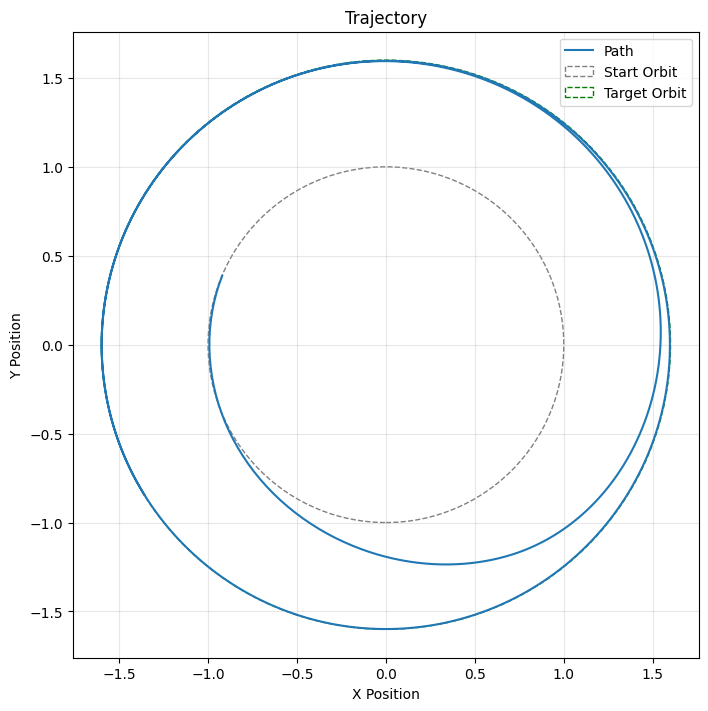

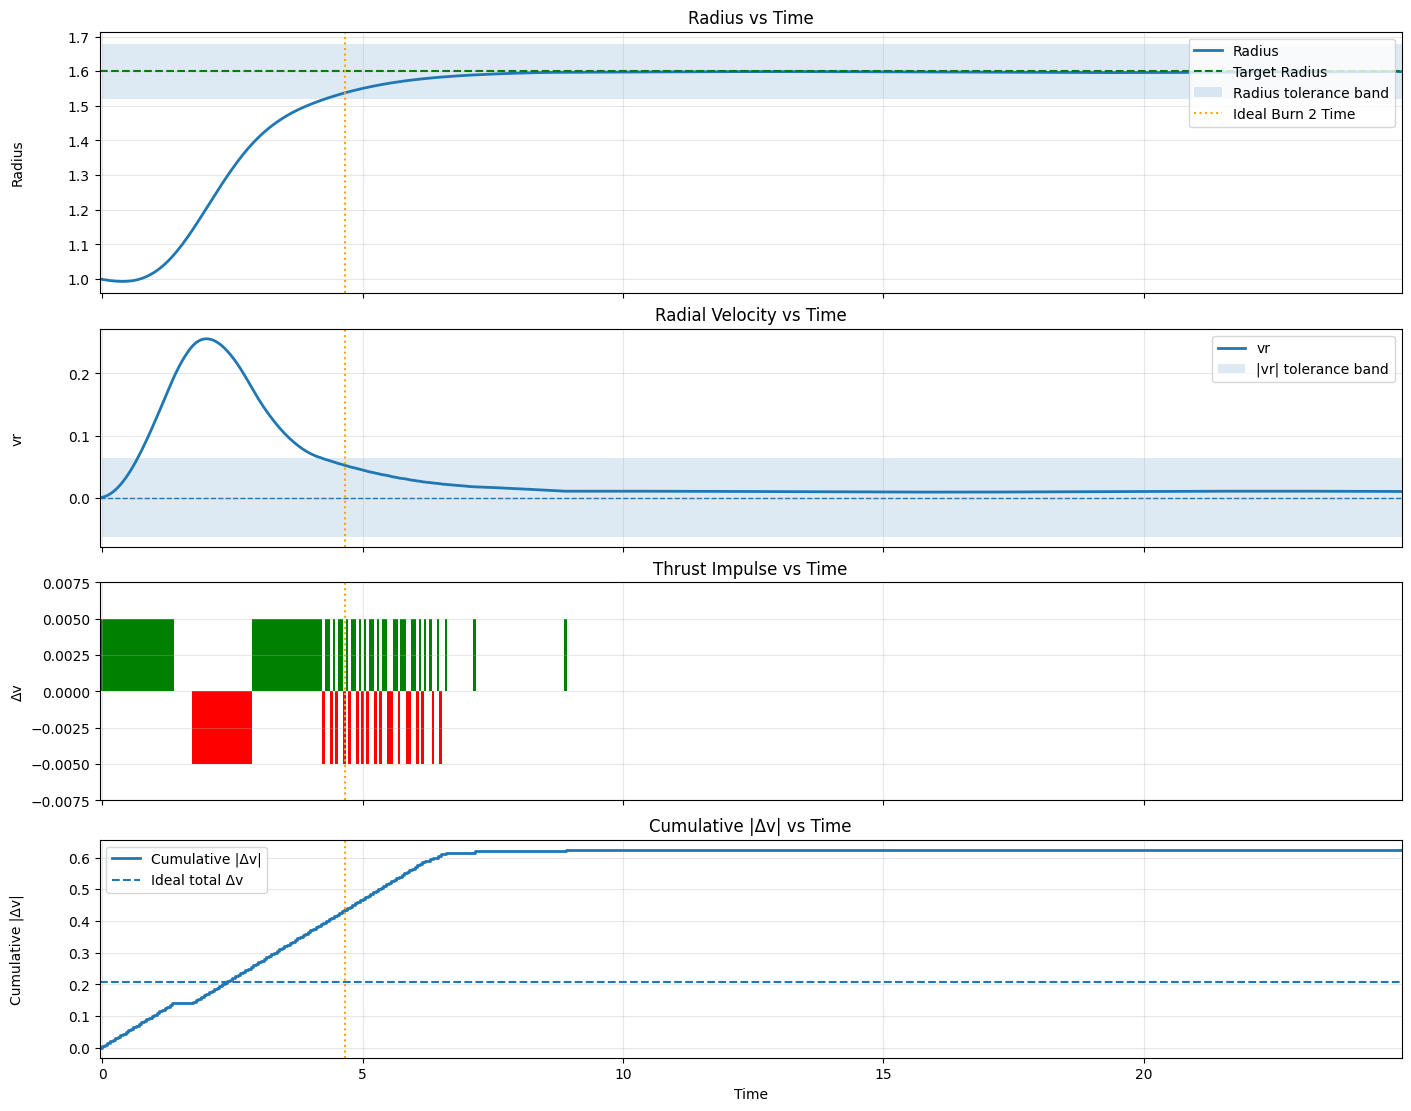

In [10]:
eval_factory_discrete = make_env_factory(mode_cfg_discrete, terminate_on_success=False)
df_discrete = visualize_agent(best_model_discrete, train_env_discrete, eval_factory_discrete, steps=500)

print_mission_report(df_discrete, mode_cfg_discrete)
plot_results(df_discrete, dv_max=mode_cfg_discrete.dv_mag)

## Experiment 2: Continuous throttle control

Now the agent can choose a throttle in [-1, +1] each step:
- small corrective burns are possible
- in principle this should reduce chattering and improve efficiency

But continuous control introduces a new failure mode:
- the policy can learn to apply tiny thrust almost constantly (“micro-thrusting”),
  which reduces error but wastes fuel.

What to look for:
- Thrust plot: many small impulses instead of a few decisive burns.
- Radius stats: it may hover around the target but remain slightly elliptical.
- Closest-to-target vs final radius: final radius can be misleading if the orbit is elliptical.

Motivation for the next experiment:
We’ll tune penalties and training budget to discourage micro-thrusting and reward efficient two-burn-like strategies.


In [11]:
# =============================================================================
# CONTINUOUS RL
# =============================================================================

mode_cfg_continuous = CONTINUOUS_CFG
train_factory_continuous = make_env_factory(mode_cfg_continuous, terminate_on_success=False)
best_model_continuous, final_model_continuous, train_env_continuous = train_ppo_agent(mode_cfg_continuous, train_factory_continuous)

Output()

Initializing PPO Agent for: Continuous
Using cpu device
Starting training for 500000 timesteps...
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    fps             | 2257     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0           |
| time/                   |             |
|    fps                  | 1719        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.002261639 |
|    clip_fraction        | 0.00801     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.0804      |
|    lea

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=10000, episode_reward=-99.91 +/- 0.00

Episode length: 156.00 +/- 0.00

Success rate: 0.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 156          |
|    mean_reward          | -99.9        |
|    success_rate         | 0            |
| time/                   |              |
|    total_timesteps      | 10000        |
| train/                  |              |
|    approx_kl            | 0.0061861672 |
|    clip_fraction        | 0.0439       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | 0.63         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0648       |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00377     |
|    std                  | 1.01         |
|    value_loss           | 0.513        |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    fps             | 1413     |
|    iterations      | 5        |
|    time_elapsed    | 7        |
|    total_timesteps | 10240    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0           |
| time/                   |             |
|    fps                  | 1410        |
|    iterations           | 6           |
|    time_elapsed         | 8           |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.009371534 |
|    clip_fraction        | 0.0789      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.815       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0822      |
|    n_updates        

Eval num_timesteps=20000, episode_reward=850.35 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 850          |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 20000        |
| train/                  |              |
|    approx_kl            | 0.0065454906 |
|    clip_fraction        | 0.0741       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0.255        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0581       |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00521     |
|    std                  | 0.972        |
|    value_loss           | 0.294        |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.0435   |
| time/              |          |
|    fps             | 1093     |
|    iterations      | 10       |
|    time_elapsed    | 18       |
|    total_timesteps | 20480    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.0426      |
| time/                   |             |
|    fps                  | 1115        |
|    iterations           | 11          |
|    time_elapsed         | 20          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.011967418 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.446       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.17        |
|    n_updates        

Eval num_timesteps=30000, episode_reward=1159.17 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.16e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 30000       |
| train/                  |             |
|    approx_kl            | 0.009595457 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.591       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0845      |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0097     |
|    std                  | 0.887       |
|    value_loss           | 0.0628      |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.0943   |
| time/              |          |
|    fps             | 1016     |
|    iterations      | 15       |
|    time_elapsed    | 30       |
|    total_timesteps | 30720    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.111       |
| time/                   |             |
|    fps                  | 1033        |
|    iterations           | 16          |
|    time_elapsed         | 31          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.015437243 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.29       |
|    explained_variance   | 0.606       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0462     |
|    n_updates        

Eval num_timesteps=40000, episode_reward=1448.56 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.45e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.008069341 |
|    clip_fraction        | 0.084       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | 0.736       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00271    |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00553    |
|    std                  | 0.815       |
|    value_loss           | 0.0212      |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.183    |
| time/              |          |
|    fps             | 979      |
|    iterations      | 20       |
|    time_elapsed    | 41       |
|    total_timesteps | 40960    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.197       |
| time/                   |             |
|    fps                  | 993         |
|    iterations           | 21          |
|    time_elapsed         | 43          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.007171677 |
|    clip_fraction        | 0.0573      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.749       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00279     |
|    n_updates        

Eval num_timesteps=50000, episode_reward=1389.72 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.39e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 50000       |
| train/                  |             |
|    approx_kl            | 0.012270076 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.13       |
|    explained_variance   | 0.796       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0108     |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00729    |
|    std                  | 0.747       |
|    value_loss           | 0.01        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.269    |
| time/              |          |
|    fps             | 9

Eval num_timesteps=60000, episode_reward=1453.58 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.45e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 60000        |
| train/                  |              |
|    approx_kl            | 0.0029475787 |
|    clip_fraction        | 0.0427       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.08        |
|    explained_variance   | 0.778        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0187      |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.00192     |
|    std                  | 0.705        |
|    value_loss           | 0.00448      |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.329    |
| time/              |          |
|    fps             | 946      |
|    iterations      | 30       |
|    time_elapsed    | 64       |
|    total_timesteps | 61440    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    success_rate         | 0.347        |
| time/                   |              |
|    fps                  | 955          |
|    iterations           | 31           |
|    time_elapsed         | 66           |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0067157145 |
|    clip_fraction        | 0.0616       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.06        |
|    explained_variance   | 0.762        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00626     |
|    n

Eval num_timesteps=70000, episode_reward=1448.79 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.45e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 70000       |
| train/                  |             |
|    approx_kl            | 0.008801173 |
|    clip_fraction        | 0.0546      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.948      |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0157     |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00279    |
|    std                  | 0.614       |
|    value_loss           | 0.00999     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.388    |
| time/              |          |
|    fps             | 9

Eval num_timesteps=80000, episode_reward=1461.05 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.46e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 80000       |
| train/                  |             |
|    approx_kl            | 0.004816981 |
|    clip_fraction        | 0.0263      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.863      |
|    explained_variance   | 0.847       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00578     |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.00502    |
|    std                  | 0.573       |
|    value_loss           | 0.00887     |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.437    |
| time/              |          |
|    fps             | 929      |
|    iterations      | 40       |
|    time_elapsed    | 88       |
|    total_timesteps | 81920    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    success_rate         | 0.449        |
| time/                   |              |
|    fps                  | 937          |
|    iterations           | 41           |
|    time_elapsed         | 89           |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0067824945 |
|    clip_fraction        | 0.0487       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.843       |
|    explained_variance   | 0.896        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00403     |
|    n

Eval num_timesteps=90000, episode_reward=1459.55 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.46e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 90000        |
| train/                  |              |
|    approx_kl            | 0.0104111545 |
|    clip_fraction        | 0.0873       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.785       |
|    explained_variance   | 0.903        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0357      |
|    n_updates            | 430          |
|    policy_gradient_loss | -0.00487     |
|    std                  | 0.522        |
|    value_loss           | 0.00411      |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.473    |
| time/              |          |
|   

Eval num_timesteps=100000, episode_reward=1427.67 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.43e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 100000       |
| train/                  |              |
|    approx_kl            | 0.0054820883 |
|    clip_fraction        | 0.0478       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.685       |
|    explained_variance   | 0.846        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0435      |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.00334     |
|    std                  | 0.474        |
|    value_loss           | 0.00304      |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.51     |
| time/              |          |
|   

Eval num_timesteps=110000, episode_reward=1494.12 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.49e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 110000       |
| train/                  |              |
|    approx_kl            | 0.0062814886 |
|    clip_fraction        | 0.0465       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.615       |
|    explained_variance   | 0.81         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000948     |
|    n_updates            | 530          |
|    policy_gradient_loss | -0.000273    |
|    std                  | 0.45         |
|    value_loss           | 0.00932      |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.57     |
| time/              |          |
|    fps             | 911      |
|    iterations      | 54       |
|    time_elapsed    | 121      |
|    total_timesteps | 110592   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.59        |
| time/                   |             |
|    fps                  | 916         |
|    iterations           | 55          |
|    time_elapsed         | 122         |
|    total_timesteps      | 112640      |
| train/                  |             |
|    approx_kl            | 0.008052362 |
|    clip_fraction        | 0.0572      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.601      |
|    explained_variance   | 0.918       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0126     |
|    n_updates        

Eval num_timesteps=120000, episode_reward=1487.95 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.49e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 120000      |
| train/                  |             |
|    approx_kl            | 0.004206586 |
|    clip_fraction        | 0.0341      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.531      |
|    explained_variance   | 0.665       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0264     |
|    n_updates            | 580         |
|    policy_gradient_loss | -0.000683   |
|    std                  | 0.411       |
|    value_loss           | 0.022       |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.64     |
| time/              |          |
|    fps             | 9

Eval num_timesteps=130000, episode_reward=1396.33 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.4e+03     |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 130000      |
| train/                  |             |
|    approx_kl            | 0.005240448 |
|    clip_fraction        | 0.0503      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.448      |
|    explained_variance   | 0.77        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00344    |
|    n_updates            | 630         |
|    policy_gradient_loss | 0.000968    |
|    std                  | 0.38        |
|    value_loss           | 0.0115      |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.71     |
| time/              |          |
|    fps             | 9

Eval num_timesteps=140000, episode_reward=1361.73 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.36e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 140000       |
| train/                  |              |
|    approx_kl            | 0.0044561466 |
|    clip_fraction        | 0.0379       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.366       |
|    explained_variance   | 0.854        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000767    |
|    n_updates            | 680          |
|    policy_gradient_loss | 1.06e-05     |
|    std                  | 0.351        |
|    value_loss           | 0.0118       |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.78     |
| time/              |          |
|   

Eval num_timesteps=150000, episode_reward=1395.79 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.4e+03     |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 150000      |
| train/                  |             |
|    approx_kl            | 0.007855933 |
|    clip_fraction        | 0.0525      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.327      |
|    explained_variance   | 0.504       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0249     |
|    n_updates            | 730         |
|    policy_gradient_loss | -0.00979    |
|    std                  | 0.332       |
|    value_loss           | 0.00877     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.85     |
| time/              |          |
|    fps             | 9

Eval num_timesteps=160000, episode_reward=1334.61 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.33e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 160000       |
| train/                  |              |
|    approx_kl            | 0.0039821523 |
|    clip_fraction        | 0.0345       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.283       |
|    explained_variance   | 0.926        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0109      |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.00216     |
|    std                  | 0.322        |
|    value_loss           | 0.0038       |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.92     |
| time/              |          |
|   

Eval num_timesteps=170000, episode_reward=1326.32 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.33e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 170000      |
| train/                  |             |
|    approx_kl            | 0.008970384 |
|    clip_fraction        | 0.0689      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0369     |
|    n_updates            | 830         |
|    policy_gradient_loss | -0.00395    |
|    std                  | 0.289       |
|    value_loss           | 0.00183     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.97     |
| time/              |          |
|    fps             | 9

Eval num_timesteps=180000, episode_reward=1356.43 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 1.49e+03  |
|    mean_reward          | 1.36e+03  |
|    success_rate         | 1         |
| time/                   |           |
|    total_timesteps      | 180000    |
| train/                  |           |
|    approx_kl            | 0.0081267 |
|    clip_fraction        | 0.0833    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0783   |
|    explained_variance   | 0.933     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0304    |
|    n_updates            | 870       |
|    policy_gradient_loss | -0.00675  |
|    std                  | 0.256     |
|    value_loss           | 0.00389   |
---------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.99     |
| time/              |          |
|    fps             | 896      |
|    iterations      | 88     

Eval num_timesteps=190000, episode_reward=1386.01 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.39e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 190000       |
| train/                  |              |
|    approx_kl            | 0.0068553924 |
|    clip_fraction        | 0.0841       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0656       |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00555      |
|    n_updates            | 920          |
|    policy_gradient_loss | -0.00201     |
|    std                  | 0.224        |
|    value_loss           | 0.00256      |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|   

Eval num_timesteps=200000, episode_reward=1415.34 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.49e+03   |
|    mean_reward          | 1.42e+03   |
|    success_rate         | 1          |
| time/                   |            |
|    total_timesteps      | 200000     |
| train/                  |            |
|    approx_kl            | 0.01534824 |
|    clip_fraction        | 0.0961     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.162      |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.000688  |
|    n_updates            | 970        |
|    policy_gradient_loss | -0.00552   |
|    std                  | 0.204      |
|    value_loss           | 0.00297    |
----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 895      |
|    itera

Eval num_timesteps=210000, episode_reward=1441.30 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.44e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 210000       |
| train/                  |              |
|    approx_kl            | 0.0047665527 |
|    clip_fraction        | 0.0818       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.282        |
|    explained_variance   | 0.885        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0231      |
|    n_updates            | 1020         |
|    policy_gradient_loss | -0.00117     |
|    std                  | 0.179        |
|    value_loss           | 0.00321      |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|   

Eval num_timesteps=220000, episode_reward=1459.01 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.46e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 220000       |
| train/                  |              |
|    approx_kl            | 0.0099031115 |
|    clip_fraction        | 0.0583       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.385        |
|    explained_variance   | 0.892        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00316     |
|    n_updates            | 1070         |
|    policy_gradient_loss | -0.00163     |
|    std                  | 0.164        |
|    value_loss           | 0.0076       |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|   

Eval num_timesteps=230000, episode_reward=1491.20 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.49e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 230000       |
| train/                  |              |
|    approx_kl            | 0.0118144015 |
|    clip_fraction        | 0.101        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.415        |
|    explained_variance   | 0.864        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.054        |
|    n_updates            | 1120         |
|    policy_gradient_loss | -0.0065      |
|    std                  | 0.158        |
|    value_loss           | 0.00247      |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|   

Eval num_timesteps=240000, episode_reward=1498.59 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.5e+03     |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 240000      |
| train/                  |             |
|    approx_kl            | 0.005278055 |
|    clip_fraction        | 0.0533      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.492       |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0193      |
|    n_updates            | 1170        |
|    policy_gradient_loss | 0.00401     |
|    std                  | 0.148       |
|    value_loss           | 0.0104      |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 893      |
|    iterations      | 118      |
|    time_elapsed    | 270      |
|    total_timesteps | 241664   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    success_rate         | 1            |
| time/                   |              |
|    fps                  | 896          |
|    iterations           | 119          |
|    time_elapsed         | 271          |
|    total_timesteps      | 243712       |
| train/                  |              |
|    approx_kl            | 0.0055231284 |
|    clip_fraction        | 0.0707       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.502        |
|    explained_variance   | 0.706        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00976     |
|    n

Eval num_timesteps=250000, episode_reward=1503.11 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.49e+03   |
|    mean_reward          | 1.5e+03    |
|    success_rate         | 1          |
| time/                   |            |
|    total_timesteps      | 250000     |
| train/                  |            |
|    approx_kl            | 0.01080009 |
|    clip_fraction        | 0.0629     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.56       |
|    explained_variance   | 0.669      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0151    |
|    n_updates            | 1220       |
|    policy_gradient_loss | 0.00444    |
|    std                  | 0.14       |
|    value_loss           | 0.0217     |
----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 893      |
|    iterations      | 123      |
|    time_elapsed    | 282      |
|    total_timesteps | 251904   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 1           |
| time/                   |             |
|    fps                  | 895         |
|    iterations           | 124         |
|    time_elapsed         | 283         |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.008569076 |
|    clip_fraction        | 0.0784      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.56        |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00784    |
|    n_updates        

Eval num_timesteps=260000, episode_reward=1505.88 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.51e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 260000      |
| train/                  |             |
|    approx_kl            | 0.010652735 |
|    clip_fraction        | 0.0639      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.634       |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0123     |
|    n_updates            | 1260        |
|    policy_gradient_loss | 0.000566    |
|    std                  | 0.126       |
|    value_loss           | 0.00118     |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 890      |
|    iterations      | 127      |
|    time_elapsed    | 292      |
|    total_timesteps | 260096   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 1           |
| time/                   |             |
|    fps                  | 892         |
|    iterations           | 128         |
|    time_elapsed         | 293         |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.064875945 |
|    clip_fraction        | 0.0904      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.659       |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00613     |
|    n_updates        

Eval num_timesteps=270000, episode_reward=1490.09 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.49e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 270000      |
| train/                  |             |
|    approx_kl            | 0.012036426 |
|    clip_fraction        | 0.0755      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.684       |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0172     |
|    n_updates            | 1310        |
|    policy_gradient_loss | 0.00243     |
|    std                  | 0.121       |
|    value_loss           | 0.00163     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=280000, episode_reward=1503.51 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.5e+03     |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 280000      |
| train/                  |             |
|    approx_kl            | 0.028347468 |
|    clip_fraction        | 0.0918      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.8         |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0184      |
|    n_updates            | 1360        |
|    policy_gradient_loss | 0.00365     |
|    std                  | 0.107       |
|    value_loss           | 0.00163     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=290000, episode_reward=1504.44 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.49e+03   |
|    mean_reward          | 1.5e+03    |
|    success_rate         | 1          |
| time/                   |            |
|    total_timesteps      | 290000     |
| train/                  |            |
|    approx_kl            | 0.02711733 |
|    clip_fraction        | 0.0965     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.851      |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.034     |
|    n_updates            | 1410       |
|    policy_gradient_loss | 0.00214    |
|    std                  | 0.103      |
|    value_loss           | 0.00418    |
----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 889      |
|    itera

Eval num_timesteps=300000, episode_reward=1498.42 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.5e+03     |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 300000      |
| train/                  |             |
|    approx_kl            | 0.023005921 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.943       |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00429    |
|    n_updates            | 1460        |
|    policy_gradient_loss | 0.00175     |
|    std                  | 0.0943      |
|    value_loss           | 0.00515     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=310000, episode_reward=1497.75 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.49e+03   |
|    mean_reward          | 1.5e+03    |
|    success_rate         | 1          |
| time/                   |            |
|    total_timesteps      | 310000     |
| train/                  |            |
|    approx_kl            | 0.04390666 |
|    clip_fraction        | 0.0865     |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.01       |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0122     |
|    n_updates            | 1510       |
|    policy_gradient_loss | 0.00828    |
|    std                  | 0.0876     |
|    value_loss           | 0.00191    |
----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 889      |
|    itera

Eval num_timesteps=320000, episode_reward=1504.44 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.5e+03     |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 320000      |
| train/                  |             |
|    approx_kl            | 0.022400472 |
|    clip_fraction        | 0.0908      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.13        |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0102     |
|    n_updates            | 1560        |
|    policy_gradient_loss | 0.00623     |
|    std                  | 0.077       |
|    value_loss           | 0.00119     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=330000, episode_reward=1493.16 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.49e+03   |
|    mean_reward          | 1.49e+03   |
|    success_rate         | 1          |
| time/                   |            |
|    total_timesteps      | 330000     |
| train/                  |            |
|    approx_kl            | 0.02340537 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.19       |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0182    |
|    n_updates            | 1610       |
|    policy_gradient_loss | 0.00213    |
|    std                  | 0.0727     |
|    value_loss           | 0.00252    |
----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 888      |
|    itera

Eval num_timesteps=340000, episode_reward=1492.29 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.49e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 340000      |
| train/                  |             |
|    approx_kl            | 0.047915973 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.23        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0158      |
|    n_updates            | 1660        |
|    policy_gradient_loss | 0.00995     |
|    std                  | 0.0699      |
|    value_loss           | 0.000665    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=350000, episode_reward=1488.72 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.49e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 350000      |
| train/                  |             |
|    approx_kl            | 0.021279788 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.26        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00527    |
|    n_updates            | 1700        |
|    policy_gradient_loss | 0.0167      |
|    std                  | 0.0688      |
|    value_loss           | 0.00148     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=360000, episode_reward=1486.04 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.49e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 360000      |
| train/                  |             |
|    approx_kl            | 0.043512158 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.27        |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0138      |
|    n_updates            | 1750        |
|    policy_gradient_loss | 0.001       |
|    std                  | 0.0684      |
|    value_loss           | 0.00213     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=370000, episode_reward=1483.77 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.48e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 370000      |
| train/                  |             |
|    approx_kl            | 0.027405636 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.29        |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00107    |
|    n_updates            | 1800        |
|    policy_gradient_loss | -0.00594    |
|    std                  | 0.0664      |
|    value_loss           | 0.00177     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=380000, episode_reward=1479.66 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.48e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 380000      |
| train/                  |             |
|    approx_kl            | 0.027527604 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.26        |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0695      |
|    n_updates            | 1850        |
|    policy_gradient_loss | 0.00532     |
|    std                  | 0.0679      |
|    value_loss           | 0.0013      |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=390000, episode_reward=1482.69 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.48e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 390000      |
| train/                  |             |
|    approx_kl            | 0.010997951 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.34        |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00366     |
|    n_updates            | 1900        |
|    policy_gradient_loss | 0.00532     |
|    std                  | 0.0633      |
|    value_loss           | 0.00176     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=400000, episode_reward=1484.49 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.48e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 400000      |
| train/                  |             |
|    approx_kl            | 0.015706917 |
|    clip_fraction        | 0.0976      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.35        |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0134      |
|    n_updates            | 1950        |
|    policy_gradient_loss | 0.00984     |
|    std                  | 0.0617      |
|    value_loss           | 0.00107     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=410000, episode_reward=1485.74 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.49e+03   |
|    mean_reward          | 1.49e+03   |
|    success_rate         | 1          |
| time/                   |            |
|    total_timesteps      | 410000     |
| train/                  |            |
|    approx_kl            | 0.02082804 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.4        |
|    explained_variance   | 0.957      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00205    |
|    n_updates            | 2000       |
|    policy_gradient_loss | 0.00962    |
|    std                  | 0.0595     |
|    value_loss           | 0.0049     |
----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 887      |
|    itera

Eval num_timesteps=420000, episode_reward=1491.38 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.49e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 420000      |
| train/                  |             |
|    approx_kl            | 0.021304388 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.43        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0091     |
|    n_updates            | 2050        |
|    policy_gradient_loss | 0.0118      |
|    std                  | 0.0578      |
|    value_loss           | 0.00126     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=430000, episode_reward=1487.66 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.49e+03   |
|    mean_reward          | 1.49e+03   |
|    success_rate         | 1          |
| time/                   |            |
|    total_timesteps      | 430000     |
| train/                  |            |
|    approx_kl            | 0.04572195 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.49       |
|    explained_variance   | 0.962      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0863     |
|    n_updates            | 2090       |
|    policy_gradient_loss | 0.0245     |
|    std                  | 0.0549     |
|    value_loss           | 0.000831   |
----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 885      |
|    itera

Eval num_timesteps=440000, episode_reward=1481.59 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.48e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 440000      |
| train/                  |             |
|    approx_kl            | 0.025594156 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.52        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0576      |
|    n_updates            | 2140        |
|    policy_gradient_loss | 0.0107      |
|    std                  | 0.0529      |
|    value_loss           | 0.000485    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=450000, episode_reward=1469.61 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.47e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 450000      |
| train/                  |             |
|    approx_kl            | 0.026061121 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.46        |
|    explained_variance   | 0.761       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0557      |
|    n_updates            | 2190        |
|    policy_gradient_loss | 0.00696     |
|    std                  | 0.0558      |
|    value_loss           | 0.00512     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=460000, episode_reward=1473.55 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.49e+03   |
|    mean_reward          | 1.47e+03   |
|    success_rate         | 1          |
| time/                   |            |
|    total_timesteps      | 460000     |
| train/                  |            |
|    approx_kl            | 0.08187944 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.48       |
|    explained_variance   | 0.966      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00176   |
|    n_updates            | 2240       |
|    policy_gradient_loss | 0.0144     |
|    std                  | 0.0554     |
|    value_loss           | 0.00198    |
----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 885      |
|    itera

Eval num_timesteps=470000, episode_reward=1476.09 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.49e+03   |
|    mean_reward          | 1.48e+03   |
|    success_rate         | 1          |
| time/                   |            |
|    total_timesteps      | 470000     |
| train/                  |            |
|    approx_kl            | 0.03425733 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.52       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0192     |
|    n_updates            | 2290       |
|    policy_gradient_loss | 0.00748    |
|    std                  | 0.0539     |
|    value_loss           | 0.00151    |
----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 885      |
|    itera

Eval num_timesteps=480000, episode_reward=1484.34 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.48e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 480000      |
| train/                  |             |
|    approx_kl            | 0.040162057 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0154     |
|    n_updates            | 2340        |
|    policy_gradient_loss | 0.00493     |
|    std                  | 0.0512      |
|    value_loss           | 0.00393     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=490000, episode_reward=1485.13 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.49e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 490000      |
| train/                  |             |
|    approx_kl            | 0.018966116 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.6         |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0107      |
|    n_updates            | 2390        |
|    policy_gradient_loss | 0.0167      |
|    std                  | 0.0485      |
|    value_loss           | 0.000578    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=500000, episode_reward=1486.01 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.49e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 500000      |
| train/                  |             |
|    approx_kl            | 0.017933067 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.61        |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0153     |
|    n_updates            | 2440        |
|    policy_gradient_loss | 0.0116      |
|    std                  | 0.048       |
|    value_loss           | 0.000302    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Training Complete.

Loaded best model from disk (highest eval mean reward checkpoint).


Simulating Agent (500 steps)...

   MISSION REPORT: Continuous vs IDEAL   
PARAMETER            | IDEAL      | AGENT     
----------------------------------------------
Final Radius         | 1.6000     | 1.5943    
Total Delta-V        | 0.2066     | 1.4175    
Active Steps         | 2          | 114       
----------------------------------------------
Efficiency (Agent/Ideal): 6.86

Closest point to target radius:
t                 24.95
r              1.594301
dv                  0.0
vr             0.009836
E_err          0.001117
L_err          0.002352
done_reason     holding
Name: 499, dtype: object

Radius stats:
  min r:  0.9966
  max r:  1.5943
  mean r: 1.5552
  std r : 0.1248

Mean radius over last 200 steps: 1.5943 (std=0.0000)



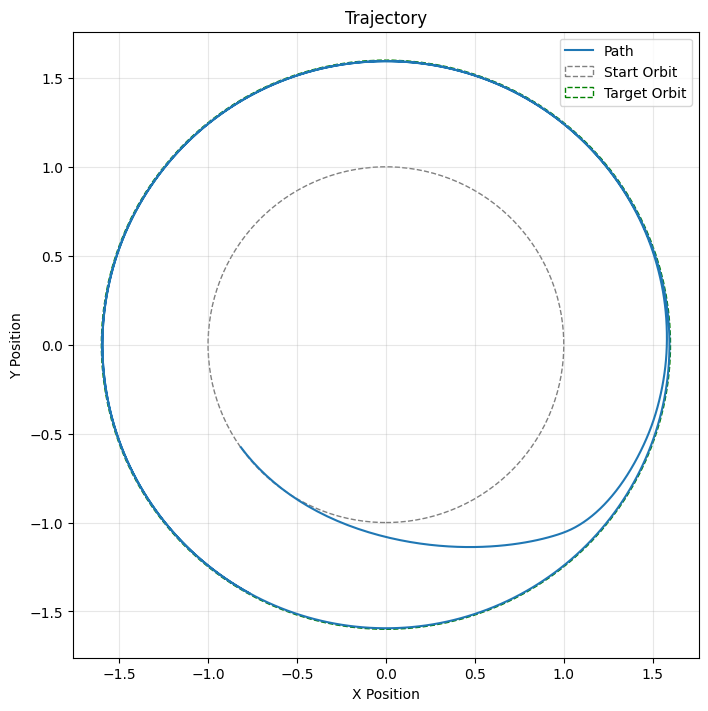

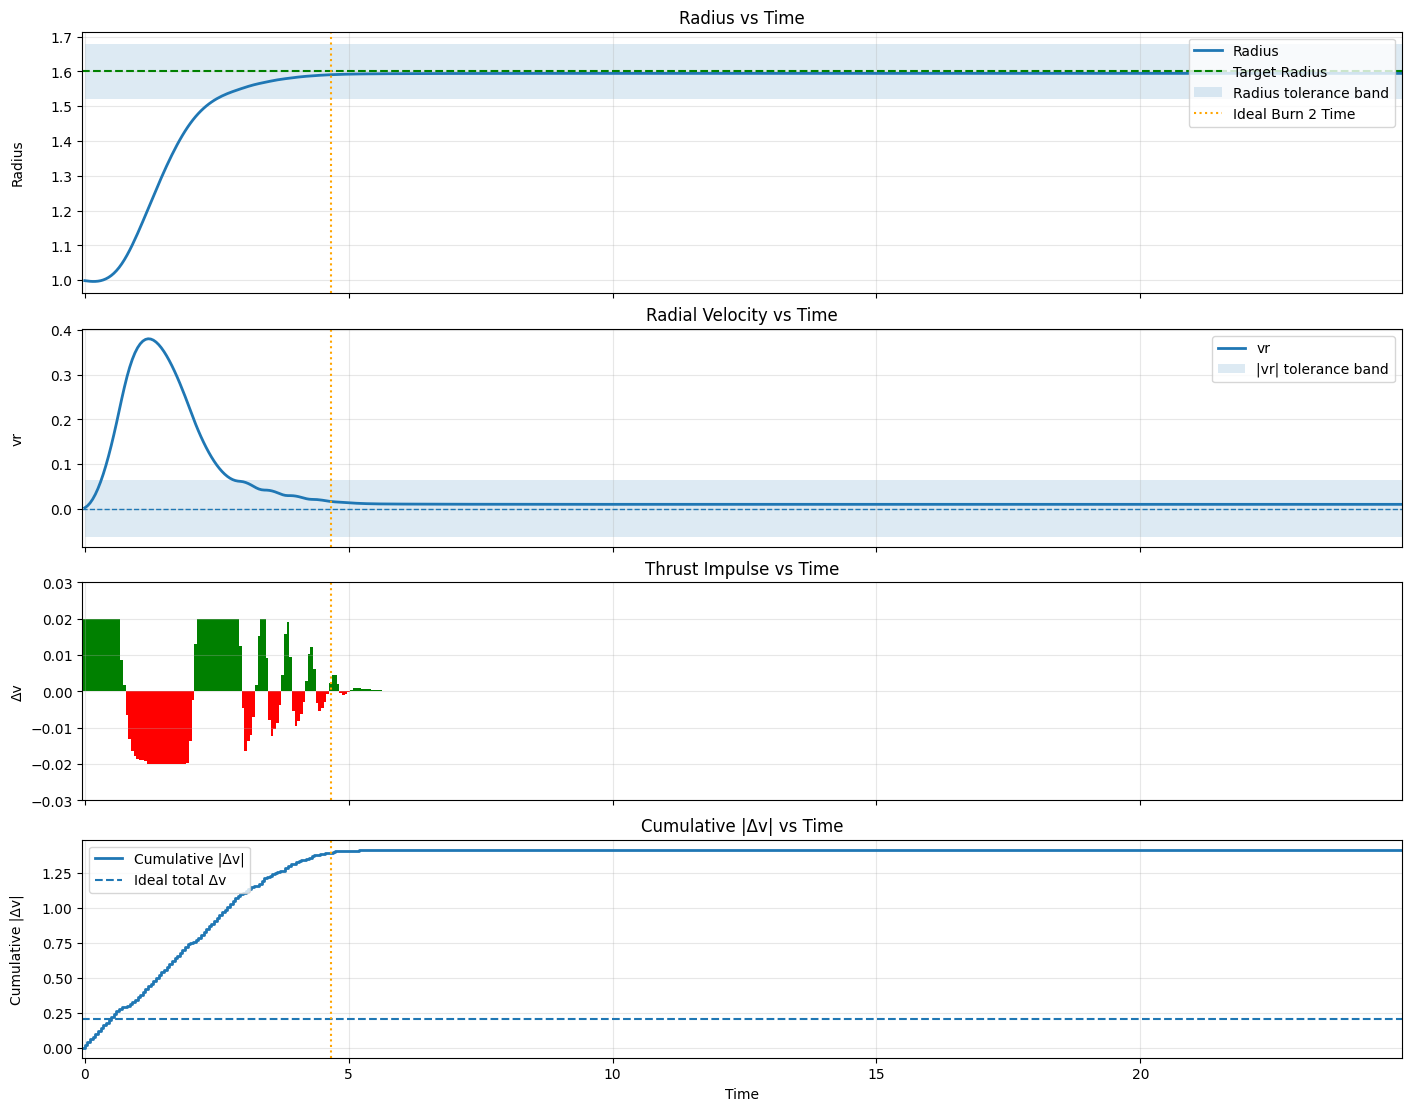

In [12]:
eval_factory_continuous = make_env_factory(mode_cfg_continuous, terminate_on_success=False)
df_continuous = visualize_agent(best_model_continuous, train_env_continuous, eval_factory_continuous, steps=500)

print_mission_report(df_continuous, mode_cfg_continuous)
plot_results(df_continuous, dv_max=mode_cfg_continuous.dv_mag)

### Experiment 3: My config

## Experiment 3: YOUR experiment (`MY_EXP`)

This is the sandbox section. You’ll create your own `ModeConfig` by modifying:
- fuel cost penalty (discourage constant thrust)
- throttle-change penalty (discourage jitter)
- max dv per step (control authority)
- reward shaping scale (how strongly we chase “being closer” vs saving fuel)
- training timesteps / entropy coefficient (learning stability vs exploration)

How we’ll “score” configs:
- Must reliably reach the target orbit region (within tolerances).
- Use as little total Δv as possible (closer to analytic ideal is better).
- Ideally: fewer active steps / smoother thrust profile.

Suggested workflow:
- Change ONE parameter at a time.
- Run training + evaluation.
- Compare plots/metrics against the previous experiment.
- Keep notes: what changed, and what evidence supports it?

Reminder:
Because success is defined with tolerances, a policy might appear to “beat” the ideal Δv by exploiting the tolerances (e.g., slightly elliptical but still within thresholds).
That’s okay for learning—just interpret the results carefully.


In [ ]:
# ---- Discrete (Bang-Bang) defaults ----
DISCRETE_CFG = ModeConfig(
    name="Discrete (Bang-Bang)",
    control_mode="discrete",
    dv_mag=0.005,                  # THRUST_DV_MAGNITUDE in discrete notebook
    fuel_cost_penalty=0.01,        # FUEL_COST_PENALTY
    ignition_penalty=0.15,         # IGNITION_PENALTY
    reward_shaping_scale=2.5,      # REWARD_SHAPING_SCALE
    discount_gamma=0.99,           # DISCOUNT_GAMMA
    success_bonus=50.0,            # SUCCESS_BONUS
    holding_reward=2.0,            # HOLDING_REWARD
    max_orbits_limit=8.0,          # MAX_ORBITS_LIMIT
    training_timesteps=300000,     # TRAINING_TIMESTEPS
    learning_rate=3e-4,            # LEARNING_RATE
    ent_coef=0.01,                 # ENT_COEF
    continuous_ignition_delta_scale=0.1,  # unused in discrete
)


# ---- Continuous defaults ----
CONTINUOUS_CFG = ModeConfig(
    name="Continuous",
    control_mode="continuous",
    dv_mag=0.02,                    # THRUST_DV_MAGNITUDE in continuous notebook (MAX per step)
    fuel_cost_penalty=0.02,        # FUEL_COST_PENALTY
    ignition_penalty=1.50,         # IGNITION_PENALTY (then scaled by 0.1 * delta throttle)
    reward_shaping_scale=1.0,      # REWARD_SHAPING_SCALE
    discount_gamma=0.99,           # DISCOUNT_GAMMA
    success_bonus=100.0,           # SUCCESS_BONUS
    holding_reward=1.0,            # HOLDING_REWARD
    max_orbits_limit=8.0,          # MAX_ORBITS_LIMIT
    training_timesteps=500000,     # TRAINING_TIMESTEPS
    learning_rate=3e-4,            # LEARNING_RATE
    ent_coef=0.01,                 # ENT_COEF
    continuous_ignition_delta_scale=0.1,  # * (IGNITION_PENALTY * 0.1)
)

In [18]:
# =============================================================================
# Do you own experimentation here!
# =============================================================================

MY_EXP = replace(
    CONTINUOUS_CFG,
    name="MY_EXP: My experiment",

    dv_mag=0.15,

    # Make fuel more expensive than baseline to discourage micro-thrusting,
    # but not so expensive that the agent refuses to burn.
    # (With dv_mag=0.02, 0.06 implies cost/Δv ~ 3.)
    fuel_cost_penalty=0.04,

    # Encourage smooth "two-burn" behavior by penalizing throttle changes more
    ignition_penalty=3,

    # Give PPO enough budget to discover + refine an efficient strategy
    training_timesteps=500_000,

    # Reduce exploration noise so it can converge to precise throttle patterns
    ent_coef=0.02,
)

mode_cfg_my_exp = MY_EXP
train_factory_my_exp = make_env_factory(mode_cfg_my_exp, terminate_on_success=False)
best_model_my_exp, final_model_my_exp, train_env_my_exp = train_ppo_agent(mode_cfg_my_exp, train_factory_my_exp)

Output()

Initializing PPO Agent for: MY_EXP: My experiment
Using cpu device
Starting training for 500000 timesteps...
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    fps             | 2246     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0           |
| time/                   |             |
|    fps                  | 1715        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008231178 |
|    clip_fraction        | 0.0758      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | -0.00494   

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=10000, episode_reward=-98.86 +/- 0.00

Episode length: 308.00 +/- 0.00

Success rate: 0.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 308         |
|    mean_reward          | -98.9       |
|    success_rate         | 0           |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.008863097 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.78        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0532      |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0102     |
|    std                  | 0.997       |
|    value_loss           | 0.248       |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    fps             | 1304     |
|    iterations      | 5        |
|    time_elapsed    | 7        |
|    total_timesteps | 10240    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0           |
| time/                   |             |
|    fps                  | 1316        |
|    iterations           | 6           |
|    time_elapsed         | 9           |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.012457775 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.791       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0547      |
|    n_updates        

Eval num_timesteps=20000, episode_reward=3.52 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 0.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 3.52        |
|    success_rate         | 0           |
| time/                   |             |
|    total_timesteps      | 20000       |
| train/                  |             |
|    approx_kl            | 0.016343903 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.579       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.364       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0249     |
|    std                  | 0.993       |
|    value_loss           | 0.719       |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    fps             | 1053     |
|    iterations      | 10       |
|    time_elapsed    | 19       |
|    total_timesteps | 20480    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0           |
| time/                   |             |
|    fps                  | 1078        |
|    iterations           | 11          |
|    time_elapsed         | 20          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.013034832 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.115       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.544       |
|    n_updates        

Eval num_timesteps=30000, episode_reward=986.87 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 987          |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 30000        |
| train/                  |              |
|    approx_kl            | 0.0034267392 |
|    clip_fraction        | 0.0336       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.33        |
|    explained_variance   | 0.0207       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0121      |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.000916    |
|    std                  | 0.908        |
|    value_loss           | 0.341        |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    fps             | 990      |
|    iterations      | 15       |
|    time_elapsed    | 31       |
|    total_timesteps | 30720    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    success_rate         | 0            |
| time/                   |              |
|    fps                  | 1007         |
|    iterations           | 16           |
|    time_elapsed         | 32           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0041181045 |
|    clip_fraction        | 0.0363       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0.034        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0191      |
|    n

Eval num_timesteps=40000, episode_reward=1128.67 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.13e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 40000        |
| train/                  |              |
|    approx_kl            | 0.0030443047 |
|    clip_fraction        | 0.0315       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.22        |
|    explained_variance   | 0.083        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.139        |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00223     |
|    std                  | 0.806        |
|    value_loss           | 0.279        |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    fps             | 960      |
|    iterations      | 20       |
|    time_elapsed    | 42       |
|    total_timesteps | 40960    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.03        |
| time/                   |             |
|    fps                  | 974         |
|    iterations           | 21          |
|    time_elapsed         | 44          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.005026725 |
|    clip_fraction        | 0.0401      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | -0.0698     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.241       |
|    n_updates        

Eval num_timesteps=50000, episode_reward=1253.19 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.25e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 50000        |
| train/                  |              |
|    approx_kl            | 0.0040340913 |
|    clip_fraction        | 0.0487       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | 0.206        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0458       |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00316     |
|    std                  | 0.709        |
|    value_loss           | 0.237        |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    fps             | 944      |
|    iterations      | 25       |
|    time_elapsed    | 54       |
|    total_timesteps | 51200    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    success_rate         | 0.04         |
| time/                   |              |
|    fps                  | 956          |
|    iterations           | 26           |
|    time_elapsed         | 55           |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0049042846 |
|    clip_fraction        | 0.0542       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.07        |
|    explained_variance   | 0.204        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0933       |
|    n

Eval num_timesteps=60000, episode_reward=1282.86 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.28e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 60000        |
| train/                  |              |
|    approx_kl            | 0.0047975173 |
|    clip_fraction        | 0.0378       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.942       |
|    explained_variance   | 0.504        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0161      |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.00386     |
|    std                  | 0.609        |
|    value_loss           | 0.1          |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    fps             | 934      |
|    iterations      | 30       |
|    time_elapsed    | 65       |
|    total_timesteps | 61440    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.05        |
| time/                   |             |
|    fps                  | 943         |
|    iterations           | 31          |
|    time_elapsed         | 67          |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.004125223 |
|    clip_fraction        | 0.0513      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.907      |
|    explained_variance   | 0.445       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0215      |
|    n_updates        

Eval num_timesteps=70000, episode_reward=1015.00 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.02e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 70000       |
| train/                  |             |
|    approx_kl            | 0.011474902 |
|    clip_fraction        | 0.079       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.806      |
|    explained_variance   | 0.464       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.087       |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00588    |
|    std                  | 0.531       |
|    value_loss           | 0.0951      |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    fps             | 9

Eval num_timesteps=80000, episode_reward=853.50 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 854          |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 80000        |
| train/                  |              |
|    approx_kl            | 0.0046689515 |
|    clip_fraction        | 0.0248       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.663       |
|    explained_variance   | 0.349        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0376       |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.00133     |
|    std                  | 0.463        |
|    value_loss           | 0.116        |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|   

Eval num_timesteps=90000, episode_reward=946.17 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 946         |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 90000       |
| train/                  |             |
|    approx_kl            | 0.005428984 |
|    clip_fraction        | 0.0816      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.578      |
|    explained_variance   | 0.637       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00557    |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.00287    |
|    std                  | 0.428       |
|    value_loss           | 0.135       |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    fps             | 9

Eval num_timesteps=100000, episode_reward=1067.71 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.07e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 100000       |
| train/                  |              |
|    approx_kl            | 0.0058961716 |
|    clip_fraction        | 0.0525       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.371       |
|    explained_variance   | 0.769        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0112      |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.00542     |
|    std                  | 0.346        |
|    value_loss           | 0.104        |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.1      |
| time/              |          |
|   

Eval num_timesteps=110000, episode_reward=1168.07 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.17e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 110000      |
| train/                  |             |
|    approx_kl            | 0.008983858 |
|    clip_fraction        | 0.0732      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.104      |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0233     |
|    n_updates            | 530         |
|    policy_gradient_loss | -0.0096     |
|    std                  | 0.261       |
|    value_loss           | 0.0152      |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.14     |
| time/              |          |
|    fps             | 9

Eval num_timesteps=120000, episode_reward=1244.15 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.24e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 120000      |
| train/                  |             |
|    approx_kl            | 0.007812387 |
|    clip_fraction        | 0.0335      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.184       |
|    explained_variance   | 0.873       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0248     |
|    n_updates            | 580         |
|    policy_gradient_loss | -0.00603    |
|    std                  | 0.196       |
|    value_loss           | 0.0197      |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.2      |
| time/              |          |
|    fps             | 9

Eval num_timesteps=130000, episode_reward=1271.87 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.27e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 130000       |
| train/                  |              |
|    approx_kl            | 0.0063948827 |
|    clip_fraction        | 0.0421       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.42         |
|    explained_variance   | 0.899        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00594      |
|    n_updates            | 630          |
|    policy_gradient_loss | -0.00459     |
|    std                  | 0.156        |
|    value_loss           | 0.0123       |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.27     |
| time/              |          |
|   

Eval num_timesteps=140000, episode_reward=1311.05 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.31e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 140000       |
| train/                  |              |
|    approx_kl            | 0.0058977054 |
|    clip_fraction        | 0.0608       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.627        |
|    explained_variance   | 0.92         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0412       |
|    n_updates            | 680          |
|    policy_gradient_loss | -0.00528     |
|    std                  | 0.127        |
|    value_loss           | 0.00602      |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.33     |
| time/              |          |
|    fps             | 900      |
|    iterations      | 69       |
|    time_elapsed    | 156      |
|    total_timesteps | 141312   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    success_rate         | 0.35         |
| time/                   |              |
|    fps                  | 905          |
|    iterations           | 70           |
|    time_elapsed         | 158          |
|    total_timesteps      | 143360       |
| train/                  |              |
|    approx_kl            | 0.0076095467 |
|    clip_fraction        | 0.0723       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.669        |
|    explained_variance   | 0.872        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.02         |
|    n

Eval num_timesteps=150000, episode_reward=1401.25 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.4e+03      |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 150000       |
| train/                  |              |
|    approx_kl            | 0.0066916468 |
|    clip_fraction        | 0.0846       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.775        |
|    explained_variance   | 0.966        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0164      |
|    n_updates            | 730          |
|    policy_gradient_loss | -0.00992     |
|    std                  | 0.109        |
|    value_loss           | 0.00206      |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.4      |
| time/              |          |
|    fps             | 899      |
|    iterations      | 74       |
|    time_elapsed    | 168      |
|    total_timesteps | 151552   |
---------------------------------
----------------------------------------
| rollout/                |            |
|    success_rate         | 0.42       |
| time/                   |            |
|    fps                  | 903        |
|    iterations           | 75         |
|    time_elapsed         | 170        |
|    total_timesteps      | 153600     |
| train/                  |            |
|    approx_kl            | 0.00909071 |
|    clip_fraction        | 0.11       |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.812      |
|    explained_variance   | 0.917      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00354    |
|    n_updates            | 740       

Eval num_timesteps=160000, episode_reward=1470.46 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.47e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 160000      |
| train/                  |             |
|    approx_kl            | 0.011825021 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.886       |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.033       |
|    n_updates            | 780         |
|    policy_gradient_loss | -0.00511    |
|    std                  | 0.0986      |
|    value_loss           | 0.0052      |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.47     |
| time/              |          |
|    fps             | 898      |
|    iterations      | 79       |
|    time_elapsed    | 180      |
|    total_timesteps | 161792   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    success_rate         | 0.49         |
| time/                   |              |
|    fps                  | 902          |
|    iterations           | 80           |
|    time_elapsed         | 181          |
|    total_timesteps      | 163840       |
| train/                  |              |
|    approx_kl            | 0.0038039666 |
|    clip_fraction        | 0.0604       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.914        |
|    explained_variance   | 0.911        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0179       |
|    n

Eval num_timesteps=170000, episode_reward=1445.11 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.45e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 170000       |
| train/                  |              |
|    approx_kl            | 0.0034386194 |
|    clip_fraction        | 0.0437       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.995        |
|    explained_variance   | 0.911        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0385       |
|    n_updates            | 830          |
|    policy_gradient_loss | 0.00133      |
|    std                  | 0.0892       |
|    value_loss           | 0.0083       |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.53     |
| time/              |          |
|   

Eval num_timesteps=180000, episode_reward=1405.45 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.41e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 180000      |
| train/                  |             |
|    approx_kl            | 0.004347435 |
|    clip_fraction        | 0.0389      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.06        |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.029       |
|    n_updates            | 870         |
|    policy_gradient_loss | -0.0047     |
|    std                  | 0.082       |
|    value_loss           | 0.0018      |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.59     |
| time/              |          |
|    fps             | 8

Eval num_timesteps=190000, episode_reward=1455.42 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.46e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 190000      |
| train/                  |             |
|    approx_kl            | 0.010469528 |
|    clip_fraction        | 0.0867      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.17        |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0431      |
|    n_updates            | 920         |
|    policy_gradient_loss | -0.000914   |
|    std                  | 0.0751      |
|    value_loss           | 0.00214     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.63     |
| time/              |          |
|    fps             | 8

Eval num_timesteps=200000, episode_reward=1493.71 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.49e+03   |
|    mean_reward          | 1.49e+03   |
|    success_rate         | 1          |
| time/                   |            |
|    total_timesteps      | 200000     |
| train/                  |            |
|    approx_kl            | 0.00554037 |
|    clip_fraction        | 0.0436     |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.25       |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.017      |
|    n_updates            | 970        |
|    policy_gradient_loss | -0.000263  |
|    std                  | 0.0687     |
|    value_loss           | 0.00342    |
----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.68     |
| time/              |          |
|    fps             | 891      |
|    iterations      | 98       |
|    time_elapsed    | 225      |
|    total_timesteps | 200704   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.7         |
| time/                   |             |
|    fps                  | 894         |
|    iterations           | 99          |
|    time_elapsed         | 226         |
|    total_timesteps      | 202752      |
| train/                  |             |
|    approx_kl            | 0.007610219 |
|    clip_fraction        | 0.0638      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.26        |
|    explained_variance   | 0.842       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0555      |
|    n_updates        

Eval num_timesteps=210000, episode_reward=1450.19 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.45e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 210000      |
| train/                  |             |
|    approx_kl            | 0.004044921 |
|    clip_fraction        | 0.0307      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.3         |
|    explained_variance   | 0.897       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0443      |
|    n_updates            | 1020        |
|    policy_gradient_loss | 0.00188     |
|    std                  | 0.0659      |
|    value_loss           | 0.00347     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.75     |
| time/              |          |
|    fps             | 8

Eval num_timesteps=220000, episode_reward=1487.18 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.49e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 220000      |
| train/                  |             |
|    approx_kl            | 0.010008857 |
|    clip_fraction        | 0.0591      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.33        |
|    explained_variance   | 0.825       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0264      |
|    n_updates            | 1070        |
|    policy_gradient_loss | -0.000348   |
|    std                  | 0.0633      |
|    value_loss           | 0.0129      |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.81     |
| time/              |          |
|    fps             | 8

Eval num_timesteps=230000, episode_reward=1496.70 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.5e+03     |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 230000      |
| train/                  |             |
|    approx_kl            | 0.004174555 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.34        |
|    explained_variance   | 0.882       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0153      |
|    n_updates            | 1120        |
|    policy_gradient_loss | 0.0011      |
|    std                  | 0.0634      |
|    value_loss           | 0.00238     |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.86     |
| time/              |          |
|    fps             | 890      |
|    iterations      | 113      |
|    time_elapsed    | 259      |
|    total_timesteps | 231424   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.87        |
| time/                   |             |
|    fps                  | 893         |
|    iterations           | 114         |
|    time_elapsed         | 261         |
|    total_timesteps      | 233472      |
| train/                  |             |
|    approx_kl            | 0.005484145 |
|    clip_fraction        | 0.0362      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.36        |
|    explained_variance   | 0.923       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0224      |
|    n_updates        

Eval num_timesteps=240000, episode_reward=1487.67 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.49e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 240000       |
| train/                  |              |
|    approx_kl            | 0.0053524952 |
|    clip_fraction        | 0.0428       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.41         |
|    explained_variance   | 0.851        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0904       |
|    n_updates            | 1170         |
|    policy_gradient_loss | 0.00148      |
|    std                  | 0.0593       |
|    value_loss           | 0.00179      |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.92     |
| time/              |          |
|   

Eval num_timesteps=250000, episode_reward=1501.79 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.5e+03     |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 250000      |
| train/                  |             |
|    approx_kl            | 0.005450367 |
|    clip_fraction        | 0.0518      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.44        |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0326      |
|    n_updates            | 1220        |
|    policy_gradient_loss | -0.00401    |
|    std                  | 0.0563      |
|    value_loss           | 0.00171     |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.96     |
| time/              |          |
|    fps             | 890      |
|    iterations      | 123      |
|    time_elapsed    | 283      |
|    total_timesteps | 251904   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.96        |
| time/                   |             |
|    fps                  | 892         |
|    iterations           | 124         |
|    time_elapsed         | 284         |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.003159867 |
|    clip_fraction        | 0.0478      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.47        |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0312      |
|    n_updates        

Eval num_timesteps=260000, episode_reward=1513.82 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.51e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 260000      |
| train/                  |             |
|    approx_kl            | 0.006176135 |
|    clip_fraction        | 0.0478      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.51        |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0294      |
|    n_updates            | 1260        |
|    policy_gradient_loss | 0.000609    |
|    std                  | 0.0533      |
|    value_loss           | 0.00318     |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 0.98     |
| time/              |          |
|    fps             | 887      |
|    iterations      | 127      |
|    time_elapsed    | 293      |
|    total_timesteps | 260096   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    success_rate         | 0.98        |
| time/                   |             |
|    fps                  | 889         |
|    iterations           | 128         |
|    time_elapsed         | 294         |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.009134805 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.51        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0277      |
|    n_updates        

Eval num_timesteps=270000, episode_reward=1485.51 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.49e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 270000      |
| train/                  |             |
|    approx_kl            | 0.007652245 |
|    clip_fraction        | 0.0481      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.54        |
|    explained_variance   | 0.815       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0314      |
|    n_updates            | 1310        |
|    policy_gradient_loss | 0.00201     |
|    std                  | 0.0515      |
|    value_loss           | 0.00836     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.99     |
| time/              |          |
|    fps             | 8

Eval num_timesteps=280000, episode_reward=1502.28 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.5e+03     |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 280000      |
| train/                  |             |
|    approx_kl            | 0.008524988 |
|    clip_fraction        | 0.0576      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.723       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000858    |
|    n_updates            | 1360        |
|    policy_gradient_loss | 0.00138     |
|    std                  | 0.0505      |
|    value_loss           | 0.00659     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.99     |
| time/              |          |
|    fps             | 8

Eval num_timesteps=290000, episode_reward=1502.54 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.5e+03     |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 290000      |
| train/                  |             |
|    approx_kl            | 0.008720346 |
|    clip_fraction        | 0.079       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0372      |
|    n_updates            | 1410        |
|    policy_gradient_loss | -0.000688   |
|    std                  | 0.0516      |
|    value_loss           | 0.00071     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.99     |
| time/              |          |
|    fps             | 8

Eval num_timesteps=300000, episode_reward=1492.95 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.49e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 300000      |
| train/                  |             |
|    approx_kl            | 0.004899717 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.58        |
|    explained_variance   | 0.94        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.037       |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.000933   |
|    std                  | 0.0493      |
|    value_loss           | 0.00155     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.99     |
| time/              |          |
|    fps             | 8

Eval num_timesteps=310000, episode_reward=1483.00 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.48e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 310000      |
| train/                  |             |
|    approx_kl            | 0.003282102 |
|    clip_fraction        | 0.0592      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.6         |
|    explained_variance   | 0.817       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0248      |
|    n_updates            | 1510        |
|    policy_gradient_loss | 0.00123     |
|    std                  | 0.0491      |
|    value_loss           | 0.00321     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.99     |
| time/              |          |
|    fps             | 8

Eval num_timesteps=320000, episode_reward=1504.07 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.5e+03      |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 320000       |
| train/                  |              |
|    approx_kl            | 0.0032819603 |
|    clip_fraction        | 0.0395       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.6          |
|    explained_variance   | 0.918        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0163       |
|    n_updates            | 1560         |
|    policy_gradient_loss | -0.000523    |
|    std                  | 0.0486       |
|    value_loss           | 0.0013       |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|   

Eval num_timesteps=330000, episode_reward=1504.43 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.5e+03      |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 330000       |
| train/                  |              |
|    approx_kl            | 0.0071936743 |
|    clip_fraction        | 0.0546       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.61         |
|    explained_variance   | 0.789        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0299       |
|    n_updates            | 1610         |
|    policy_gradient_loss | 0.000232     |
|    std                  | 0.0479       |
|    value_loss           | 0.013        |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|   

Eval num_timesteps=340000, episode_reward=1470.27 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.47e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 340000       |
| train/                  |              |
|    approx_kl            | 0.0052015428 |
|    clip_fraction        | 0.0507       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.61         |
|    explained_variance   | 0.854        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0553       |
|    n_updates            | 1660         |
|    policy_gradient_loss | 5.36e-05     |
|    std                  | 0.0484       |
|    value_loss           | 0.00942      |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|   

Eval num_timesteps=350000, episode_reward=1470.90 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.47e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 350000      |
| train/                  |             |
|    approx_kl            | 0.003937559 |
|    clip_fraction        | 0.0433      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.63        |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00304     |
|    n_updates            | 1700        |
|    policy_gradient_loss | -0.00262    |
|    std                  | 0.0474      |
|    value_loss           | 0.00227     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=360000, episode_reward=1504.98 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.49e+03   |
|    mean_reward          | 1.5e+03    |
|    success_rate         | 1          |
| time/                   |            |
|    total_timesteps      | 360000     |
| train/                  |            |
|    approx_kl            | 0.01465855 |
|    clip_fraction        | 0.0565     |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.6        |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0153     |
|    n_updates            | 1750       |
|    policy_gradient_loss | -0.00298   |
|    std                  | 0.0483     |
|    value_loss           | 0.0017     |
----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 883      |
|    itera

Eval num_timesteps=370000, episode_reward=1526.59 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.49e+03   |
|    mean_reward          | 1.53e+03   |
|    success_rate         | 1          |
| time/                   |            |
|    total_timesteps      | 370000     |
| train/                  |            |
|    approx_kl            | 0.00459309 |
|    clip_fraction        | 0.0442     |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.61       |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0275     |
|    n_updates            | 1800       |
|    policy_gradient_loss | 0.00138    |
|    std                  | 0.0479     |
|    value_loss           | 0.00131    |
----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 883      |
|    iterations      | 181      |
|    time_elapsed    | 419      |
|    total_timesteps | 370688   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    success_rate         | 1            |
| time/                   |              |
|    fps                  | 885          |
|    iterations           | 182          |
|    time_elapsed         | 421          |
|    total_timesteps      | 372736       |
| train/                  |              |
|    approx_kl            | 0.0033818705 |
|    clip_fraction        | 0.0334       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.62         |
|    explained_variance   | 0.479        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0522       |
|    n

Eval num_timesteps=380000, episode_reward=1479.88 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1.49e+03   |
|    mean_reward          | 1.48e+03   |
|    success_rate         | 1          |
| time/                   |            |
|    total_timesteps      | 380000     |
| train/                  |            |
|    approx_kl            | 0.03283635 |
|    clip_fraction        | 0.0652     |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.65       |
|    explained_variance   | 0.513      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.000171   |
|    n_updates            | 1850       |
|    policy_gradient_loss | 0.00584    |
|    std                  | 0.046      |
|    value_loss           | 0.00374    |
----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 883      |
|    itera

Eval num_timesteps=390000, episode_reward=1495.34 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.5e+03     |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 390000      |
| train/                  |             |
|    approx_kl            | 0.005782244 |
|    clip_fraction        | 0.0792      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.67        |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0133      |
|    n_updates            | 1900        |
|    policy_gradient_loss | 0.00422     |
|    std                  | 0.0458      |
|    value_loss           | 0.00574     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=400000, episode_reward=1479.37 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.48e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 400000       |
| train/                  |              |
|    approx_kl            | 0.0069613094 |
|    clip_fraction        | 0.0497       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.6          |
|    explained_variance   | 0.954        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00451      |
|    n_updates            | 1950         |
|    policy_gradient_loss | 0.00351      |
|    std                  | 0.049        |
|    value_loss           | 0.00184      |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|   

Eval num_timesteps=410000, episode_reward=1460.22 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.46e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 410000      |
| train/                  |             |
|    approx_kl            | 0.003250474 |
|    clip_fraction        | 0.0519      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.59        |
|    explained_variance   | 0.767       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0293      |
|    n_updates            | 2000        |
|    policy_gradient_loss | 0.000188    |
|    std                  | 0.049       |
|    value_loss           | 0.00396     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=420000, episode_reward=1450.79 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.45e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 420000      |
| train/                  |             |
|    approx_kl            | 0.013931855 |
|    clip_fraction        | 0.0584      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.59        |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00571    |
|    n_updates            | 2050        |
|    policy_gradient_loss | 0.0044      |
|    std                  | 0.0494      |
|    value_loss           | 0.00186     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=430000, episode_reward=1448.24 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.45e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 430000      |
| train/                  |             |
|    approx_kl            | 0.009952489 |
|    clip_fraction        | 0.0457      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.307       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0266      |
|    n_updates            | 2090        |
|    policy_gradient_loss | 0.00606     |
|    std                  | 0.0499      |
|    value_loss           | 0.00295     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=440000, episode_reward=1459.34 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.46e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 440000      |
| train/                  |             |
|    approx_kl            | 0.004929072 |
|    clip_fraction        | 0.0489      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.64        |
|    explained_variance   | 0.827       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0336      |
|    n_updates            | 2140        |
|    policy_gradient_loss | 0.00309     |
|    std                  | 0.047       |
|    value_loss           | 0.00727     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=450000, episode_reward=1427.76 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.43e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 450000      |
| train/                  |             |
|    approx_kl            | 0.040450282 |
|    clip_fraction        | 0.0412      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.68        |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.135       |
|    n_updates            | 2190        |
|    policy_gradient_loss | 0.002       |
|    std                  | 0.0454      |
|    value_loss           | 0.0015      |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=460000, episode_reward=1433.34 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.43e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 460000       |
| train/                  |              |
|    approx_kl            | 0.0075465804 |
|    clip_fraction        | 0.0912       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.66         |
|    explained_variance   | 0.93         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0267       |
|    n_updates            | 2240         |
|    policy_gradient_loss | -0.00254     |
|    std                  | 0.0465       |
|    value_loss           | 0.00231      |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|   

Eval num_timesteps=470000, episode_reward=1442.70 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.44e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 470000      |
| train/                  |             |
|    approx_kl            | 0.015968498 |
|    clip_fraction        | 0.0619      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.796       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.028       |
|    n_updates            | 2290        |
|    policy_gradient_loss | -0.00319    |
|    std                  | 0.0511      |
|    value_loss           | 0.00847     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=480000, episode_reward=1349.43 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.49e+03    |
|    mean_reward          | 1.35e+03    |
|    success_rate         | 1           |
| time/                   |             |
|    total_timesteps      | 480000      |
| train/                  |             |
|    approx_kl            | 0.007576951 |
|    clip_fraction        | 0.0343      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.488       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0515      |
|    n_updates            | 2340        |
|    policy_gradient_loss | 0.00656     |
|    std                  | 0.0515      |
|    value_loss           | 0.0144      |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|    fps             | 8

Eval num_timesteps=490000, episode_reward=1426.00 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.43e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 490000       |
| train/                  |              |
|    approx_kl            | 0.0073383097 |
|    clip_fraction        | 0.0782       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.53         |
|    explained_variance   | 0.898        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0377       |
|    n_updates            | 2390         |
|    policy_gradient_loss | 0.00057      |
|    std                  | 0.0529       |
|    value_loss           | 0.0024       |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|   

Eval num_timesteps=500000, episode_reward=1463.20 +/- 0.00

Episode length: 1491.00 +/- 0.00

Success rate: 100.00%

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.49e+03     |
|    mean_reward          | 1.46e+03     |
|    success_rate         | 1            |
| time/                   |              |
|    total_timesteps      | 500000       |
| train/                  |              |
|    approx_kl            | 0.0076158023 |
|    clip_fraction        | 0.0654       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.52         |
|    explained_variance   | 0.941        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0374       |
|    n_updates            | 2440         |
|    policy_gradient_loss | -0.00159     |
|    std                  | 0.0526       |
|    value_loss           | 0.00496      |
------------------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 1        |
| time/              |          |
|   

Training Complete.

Loaded best model from disk (highest eval mean reward checkpoint).


Simulating Agent (500 steps)...

   MISSION REPORT: MY_EXP: My experiment vs IDEAL   
PARAMETER            | IDEAL      | AGENT     
----------------------------------------------
Final Radius         | 1.6000     | 1.5991    
Total Delta-V        | 0.2066     | 2.1290    
Active Steps         | 2          | 49        
----------------------------------------------
Efficiency (Agent/Ideal): 10.30

Closest point to target radius:
t                 24.95
r              1.599146
dv                  0.0
vr             0.009776
E_err          0.000167
L_err          0.000434
done_reason     holding
Name: 499, dtype: object

Radius stats:
  min r:  0.9990
  max r:  1.5991
  mean r: 1.5698
  std r : 0.0998

Mean radius over last 200 steps: 1.5991 (std=0.0000)



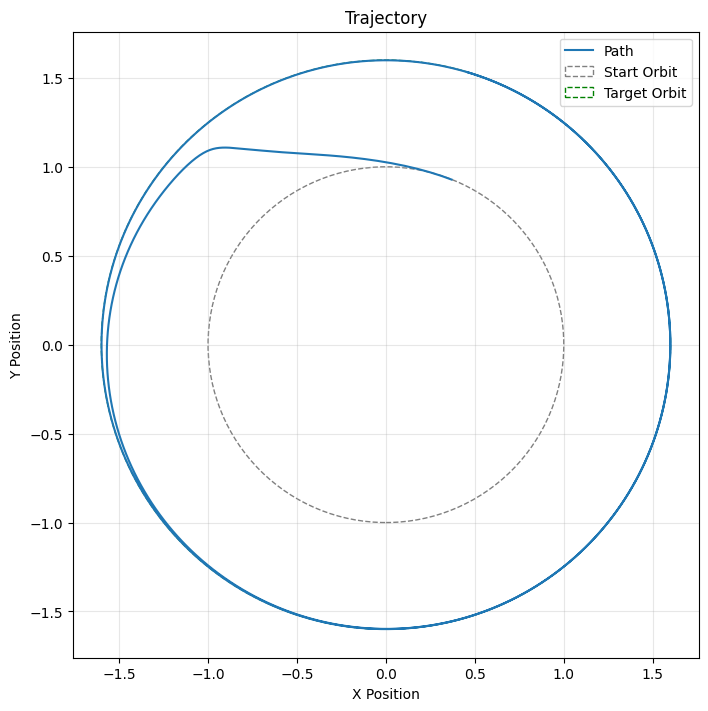

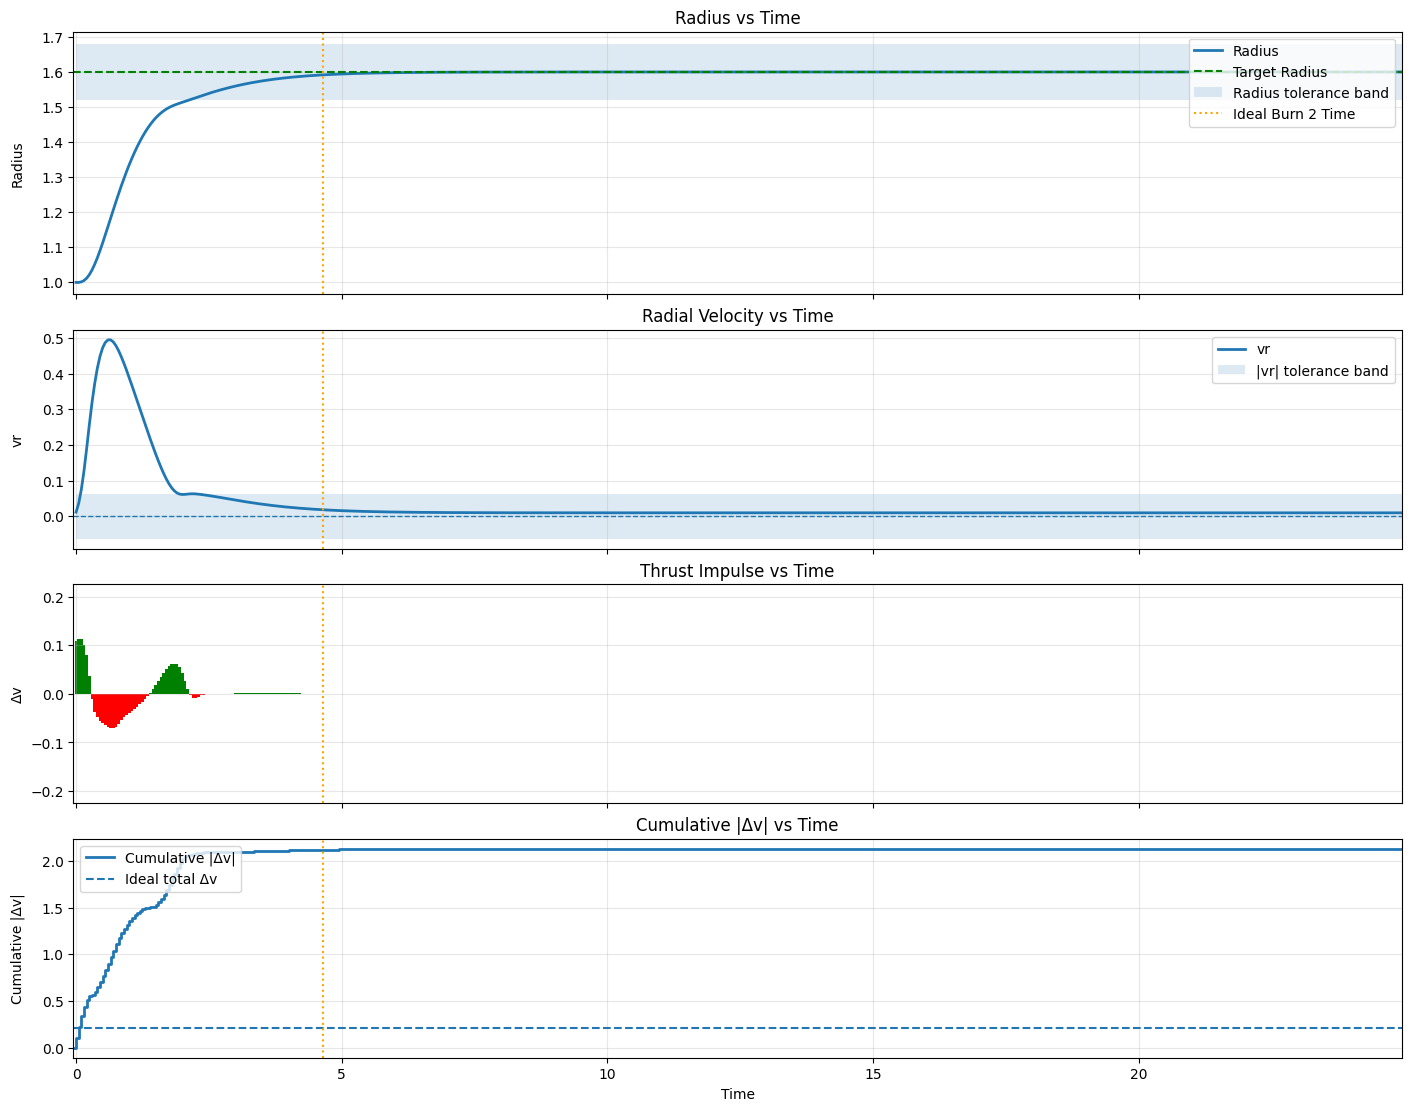

In [19]:
eval_factory_my_exp = make_env_factory(mode_cfg_my_exp, terminate_on_success=False)
df_my_exp = visualize_agent(best_model_my_exp, train_env_my_exp, eval_factory_my_exp, steps=500)

print_mission_report(df_my_exp, mode_cfg_my_exp)
plot_results(df_my_exp, dv_max=mode_cfg_my_exp.dv_mag)

In [15]:
print(mode_cfg_my_exp)

ModeConfig(name='MY_EXP: My experiment', control_mode='continuous', dv_mag=0.02, fuel_cost_penalty=0.06, ignition_penalty=3.0, reward_shaping_scale=1.5, discount_gamma=0.99, success_bonus=100.0, holding_reward=1.0, max_orbits_limit=8.0, training_timesteps=500000, learning_rate=0.0002, ent_coef=0.0, continuous_ignition_delta_scale=0.25)
